In [ ]:
import torch
import functorch

from sngrok.permutations import Permutation, make_permutation_dataset
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep

from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap

In [2]:
run = torch.load('checkpoints/s5_50_02/full_run.pth', map_location=torch.device('cpu'))

In [830]:
run['checkpoints'][10]

OrderedDict([('lembed.weight',
              tensor([[ 0.0319, -0.3399,  0.0661,  ...,  0.1508,  0.4224, -0.0792],
                      [ 0.5746, -0.4311, -0.5345,  ..., -0.3823,  0.0758, -0.2458],
                      [ 0.3328, -0.5632, -0.0659,  ..., -0.6656,  0.4398, -0.4549],
                      ...,
                      [ 0.3909, -0.3122,  0.1411,  ..., -0.3545, -0.0338,  0.6433],
                      [ 0.1416, -0.2276, -0.0015,  ..., -0.5238,  0.3275, -0.2812],
                      [ 0.2907, -0.4759, -0.4552,  ..., -0.4866,  0.3533,  0.7086]])),
             ('rembed.weight',
              tensor([[-0.3297,  0.4782, -0.4968,  ..., -0.3253, -0.1980,  0.2318],
                      [-0.2200,  0.7534, -0.6185,  ...,  0.2062, -0.1673, -0.6756],
                      [-0.4791,  0.3572, -0.6409,  ..., -0.4930,  0.3589, -0.1538],
                      ...,
                      [ 0.2257,  0.2289,  0.6621,  ...,  0.3954,  0.6920,  0.2098],
                      [-0.4245,  0.1860, 

In [3]:
run['config']

{'embed_dim': 256, 'model_dim': 128, 'vocab_size': 120, 'tie_lr': False}

In [4]:
"""
def _dot(fx, rho):
    return fx * rho

fft_dot = functorch.vmap(scalar_x_mat, in_dims=(0, 0))

def _fft_sum(fx, rho):
    if rho.dim() == 1:
        return torch.dot(fx, rho)
    else:
        return fft_dot(fx, rho).sum(dim=0)
    
fft_sum = functorch.vmap(_fft_sum, in_dims=(1, None))


def slow_ft(fn_vals, n):
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    #fn_vals = fn(permutations)
    all_irreps = [SnIrrep(n, p) for p in all_partitions]
    results = {}
    for irrep in all_irreps:
        matrices = irrep.matrix_tensor()
        results[irrep.shape] = fft_sum(fn_vals, matrices).squeeze()
    return results

"""

from sngrok.fourier import slow_ft, sn_fourier_basis

In [5]:
list(run.keys())

['model', 'config', 'checkpoints', 'checkpoint_epochs']

In [6]:
model = SnMLP.from_config(run['config'])
model.load_state_dict(run['model'])

<All keys matched successfully>

In [8]:

fourier_lembed = slow_ft(model.lembed.weight, 5)
fourier_lembed[(3, 1, 1)].shape

torch.Size([256, 6, 6])

In [818]:
fourier_lembed[(2, 1, 1, 1)][3]

tensor([[ 0.8811,  3.9989,  1.1215, -4.5421],
        [ 1.0207, -2.9652, -0.1600,  2.4941],
        [ 3.0854,  2.2872,  1.1204, -3.4922],
        [ 2.0894, -1.0773,  1.1726,  1.0010]], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [9]:
ft_decomp_lembed = sn_fourier_basis(fourier_lembed, 5)

In [11]:
ft_decomp_lembed.shape


torch.Size([120, 7, 256])

In [12]:
reshaped_lembed = ft_decomp_lembed.reshape((-1, 256))


In [15]:
lident = ft_decomp_lembed[0]
torch.equal(lident, reshaped_lembed[0:7])

True

In [33]:
import polars as pl
import math


def fourier_basis_to_df(tensor, n):
    group_order, num_irreps, fn_dim = tensor.shape
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    assert len(permutations) == group_order
    assert len(all_partitions) == num_irreps
    
    long_values = tensor.reshape((-1, fn_dim))
    group_col= []
    for s in permutations:
        group_col += [str(s.sigma)] * num_irreps
    part_col = [str(p) for p in all_partitions] * group_order
    assert len(group_col) == len(part_col) and len(group_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({'permutation': group_col, 'irrep': part_col})
    return pl.concat([sn_metadata, val_data], how='horizontal')

lembed_df = fourier_basis_to_df(ft_decomp_lembed, 5)
lembed_df.head()

permutation,irrep,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,dim34,...,dim219,dim220,dim221,dim222,dim223,dim224,dim225,dim226,dim227,dim228,dim229,dim230,dim231,dim232,dim233,dim234,dim235,dim236,dim237,dim238,dim239,dim240,dim241,dim242,dim243,dim244,dim245,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,...,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...",-0.156939,-0.227466,0.087732,0.156965,-0.128979,0.098811,0.027995,0.036726,0.227116,0.038665,-0.00369,0.00871,-0.190716,0.152936,0.21238,-0.214196,0.030951,-0.111627,-0.110501,-0.034598,-0.192036,0.023126,-0.412126,-0.114008,-0.292841,0.259591,0.085904,0.19708,0.474567,0.067753,0.237591,-0.018286,-0.26221,-0.325021,0.134981,...,-0.299829,-0.074539,-0.03563,0.070744,0.087062,-0.020902,-0.061622,0.122837,0.114011,-0.044059,-0.130871,-0.07263,-0.028401,0.004336,-0.07463,-0.024694,-0.072315,0.040199,-0.048562,-0.226973,0.09772,0.079783,0.231914,0.034608,-0.180568,0.12513,-0.025879,-0.195229,-0.071003,0.039467,-0.186864,0.2897,0.211167,0.00161,0.055233,-0.181147,0.286031
"""(0, 1, 2, 3, 4...","""(2, 1, 1, 1)""",-6.842973,4.044824,-7.580968,0.037305,-3.942723,0.031595,-2.603224,-0.437538,-9.569466,0.67323,8.804252,-1.744477,3.025674,-5.466168,2.685597,-4.013221,-5.759187,-5.148418,-0.295123,0.347296,-5.217764,-2.17858,4.831579,7.914421,-1.308774,1.708219,6.777381,-5.797256,3.658164,-6.887947,-6.928967,1.199583,5.039276,-0.804532,-0.267252,...,7.129307,0.427042,0.696598,-4.646136,2.820676,-4.006153,-1.549435,-6.474027,0.238288,-3.831786,5.955845,-0.382505,-2.486235,1.169927,-8.381307,-0.203973,-2.608344,6.391847,-5.683714,2.721699,-0.116665,-2.97648,-5.013349,3.464963,-0.08757,5.759881,-7.945421,3.954034,1.813573,5.409542,-0.962297,4.130421,-1.254878,-2.709643,-7.960359,2.968906,-2.118967
"""(0, 1, 2, 3, 4...","""(2, 2, 1)""",0.563898,-0.376961,-0.305081,-1.130039,-0.838077,-0.856229,-0.721701,0.098693,0.349547,0.50393,1.108834,0.133459,0.823522,-0.127442,-1.491555,-1.291893,-0.178563,0.099998,-0.81848,-0.17927,0.332179,1.122595,0.314422,-0.686779,-0.265607,0.310882,-0.116149,-1.251246,-0.352119,0.017747,0.751593,-1.311334,1.235086,0.830485,0.240328,...,-0.519931,0.050108,-0.380819,-0.0762,0.672125,-0.489037,-0.118313,-1.551887,0.3785,-1.088479,0.247937,-0.292804,-0.821076,1.034543,-0.313911,-0.063279,-0.1199,0.288086,0.388054,0.238542,-0.70065,1.308803,0.306678,1.37213,-0.106654,1.069446,0.315371,-0.236518,-0.04697,0.602429,-1.454304,-0.079891,-0.364713,0.730056,1.03616,0.450152,-0.858346
"""(0, 1, 2, 3, 4...","""(3, 1, 1)""",0.034046,0.277547,0.325305,0.133025,-0.009521,-0.052684,-0.057944,0.151107,0.335305,0.269895,-0.11231,-0.156293,-0.043703,-0.115688,0.143524,-0.509033,0.129091,0.102531,-0.261615,0.02155,-0.189598,-0.086817,-0.116661,-0.062613,-0.33024,-0.154843,0.187861,0.003453,0.063658,-0.024252,-0.245809,-0.009634,0.058857,-0.072667,0.144011,...,-0.177443,-0.038175,0.434803,0.030495,-0.258858,-0.103389,0.346621,0.276772,-0.207813,-0.175618,-0.100002,-0.025409,0.343212,-0.061911,0.121765,0.041052,-0.162303,-0.211053,0.31247,-0.079977,0.07726,0.081229,-0.134847,0.323256,-0.260802,0.10777,0.118738,0.293695,0.063636,0.278597,0.012084,0.011815,0.176499,-0.124396,0.12684,0.0745,0.004824
"""(0, 1, 2, 3, 4...","""(3, 2)""",-0.833493,0.307967,-3.27977,-0.653059,-2.344295,0.71002,-1.802344,-2.925403,1.836493,2.256682,-3.492033,-2.594257,-1.634943,-0.960842,1.131141,0.324455,-2.817858,-2.798849,-1.400287,2.808039,-2.709987,-0.009841,0.297578,-2.438162,-2.822109,3.165303,-0.808926,-0.835139,3.329852,-0.456812,-2.512401,0.11304

In [34]:
#.head()

lembed_df.select(['permutation', 'irrep', 'dim0', 'dim1']).head(20)

permutation,irrep,dim0,dim1
str,str,f64,f64
"""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...",-0.156939,-0.227466
"""(0, 1, 2, 3, 4...","""(2, 1, 1, 1)""",-6.842973,4.044824
"""(0, 1, 2, 3, 4...","""(2, 2, 1)""",0.563898,-0.376961
"""(0, 1, 2, 3, 4...","""(3, 1, 1)""",0.034046,0.277547
"""(0, 1, 2, 3, 4...","""(3, 2)""",-0.833493,0.307967
"""(0, 1, 2, 3, 4...","""(4, 1)""",0.327888,-0.442916
"""(0, 1, 2, 3, 4...","""(5,)""",-6.635604,-6.239559
"""(0, 1, 3, 4, 2...","""(1, 1, 1, 1, 1...",-0.156939,-0.227466
"""(0, 1, 3, 4, 2...","""(2, 1, 1, 1)""",-2.63956,-6.112335


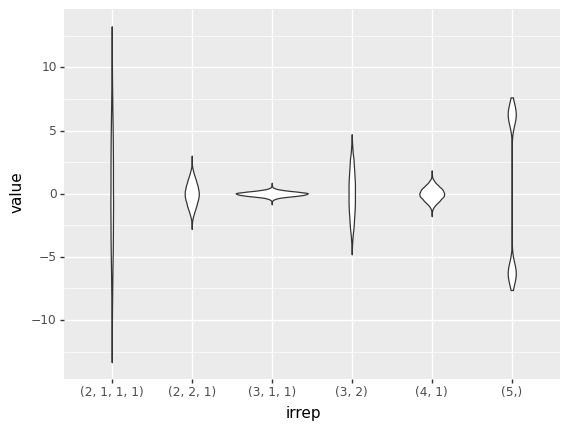

<ggplot: (360513885)>

In [35]:
from plotnine import ggplot, geom_point, geom_histogram, geom_violin, aes, stat_smooth, facet_wrap

df = lembed_df.melt(id_vars=['permutation', 'irrep']).filter(pl.col('irrep') != "(1, 1, 1, 1, 1)").to_pandas()

(
    ggplot(df, aes(x='irrep', y='value')) + geom_violin()
)

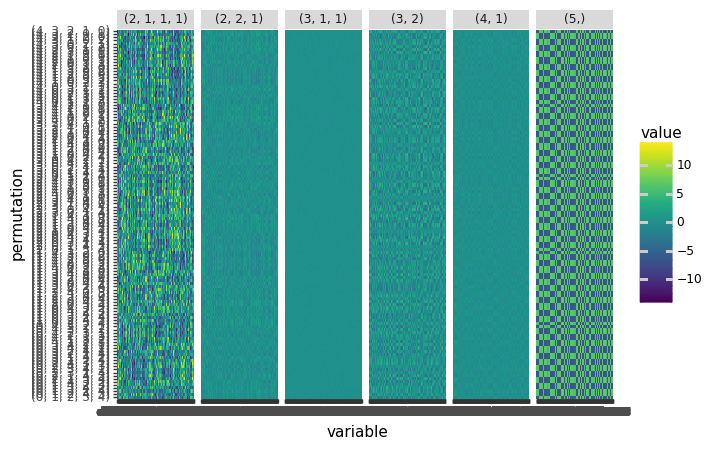

<ggplot: (723218589)>

In [41]:
from plotnine import geom_tile

(
    ggplot(df, aes(x='variable', y='permutation', fill='value')) 
    + geom_tile()
    + facet_wrap('~irrep', ncol=6)
)

In [42]:
lembed_df.melt(id_vars=['permutation', 'irrep']).head(20)

permutation,irrep,variable,value
str,str,str,f64
"""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...","""dim0""",-0.156939
"""(0, 1, 2, 3, 4...","""(2, 1, 1, 1)""","""dim0""",-6.842973
"""(0, 1, 2, 3, 4...","""(2, 2, 1)""","""dim0""",0.563898
"""(0, 1, 2, 3, 4...","""(3, 1, 1)""","""dim0""",0.034046
"""(0, 1, 2, 3, 4...","""(3, 2)""","""dim0""",-0.833493
"""(0, 1, 2, 3, 4...","""(4, 1)""","""dim0""",0.327888
"""(0, 1, 2, 3, 4...","""(5,)""","""dim0""",-6.635604
"""(0, 1, 3, 4, 2...","""(1, 1, 1, 1, 1...","""dim0""",-0.156939
"""(0, 1, 3, 4, 2...","""(2, 1, 1, 1)""","""dim0""",-2.63956


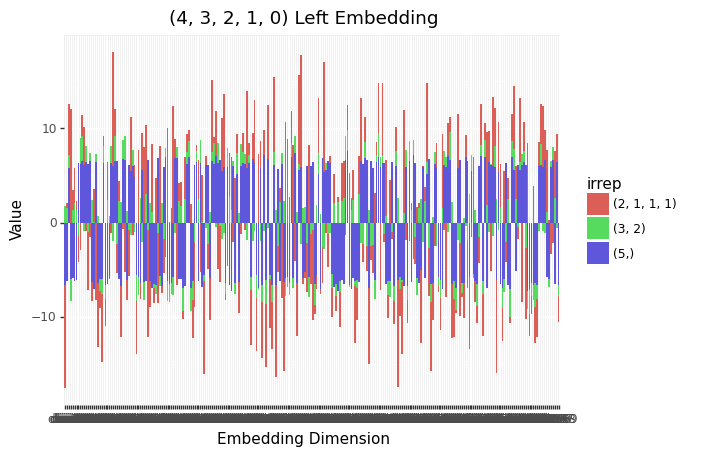

<ggplot: (716578357)>

In [823]:
from plotnine import geom_col, xlab, ylab, ggtitle

#df = lembed_df.melt(id_vars=['permutation', 'irrep']).filter((
    #pl.col('permutation') =="(0, 1, 2, 3, 4)") | (pl.col('permutation') == "(1, 0, 2, 3, 4)")
#).to_pandas()
df = lembed_df.melt(id_vars=['permutation', 'irrep']).filter((
    (pl.col('permutation') =="(4, 3, 2, 1, 0)"))
    & (pl.col('irrep').is_in(["(5,)", "(2, 1, 1, 1)", "(3, 2)"]))
).to_pandas()


(
    ggplot(df, aes(x='variable', y='value', fill='irrep')) + geom_col() + xlab('Embedding Dimension') + ylab('Value') + ggtitle('(4, 3, 2, 1, 0) Left Embedding')
)

In [62]:
def make_embed_barplot(data, perm, title_prefix):
    df = data.melt(id_vars=['permutation', 'irrep']).filter((
        pl.col('permutation') == str(perm.sigma))
    ).to_pandas()
    return (
        ggplot(df, aes(x='variable', y='value')) 
        + geom_col()
        + facet_wrap('~irrep') 
        + xlab('Embedding Dimension')
        + ylab('Value')
        + ggtitle(f'{title_prefix}: {str(perm.sigma)}')
    )

S5 = Permutation.full_group(5)


In [59]:
''.join([str(i) for i in (0, 1, 2, 3, 4)])

'01234'

In [64]:
for perm in S5:
    plot = make_embed_barplot(lembed_df, perm, 'Left Embed')
    filename = ''.join([str(i) for i in perm.sigma]) + '.png'
    plot.save(f'plots/lembed_dist/{filename}', verbose=False)

In [65]:
fourier_rembed = slow_ft(model.rembed.weight, 5)
ft_decomp_rembed = sn_fourier_basis(fourier_rembed, 5)
rembed_df = fourier_basis_to_df(ft_decomp_rembed, 5)


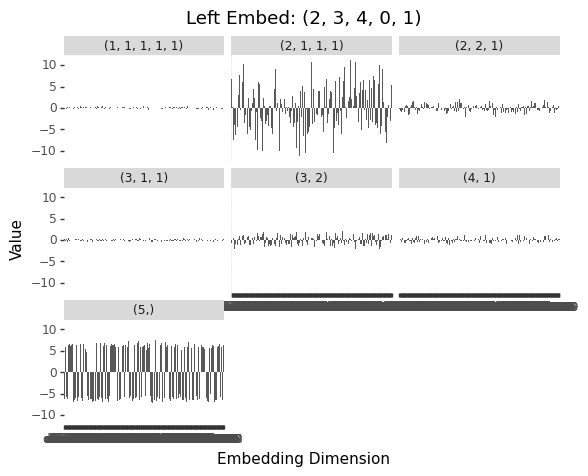

<ggplot: (706798049)>

In [67]:
make_embed_barplot(lembed_df, S5[32], 'Left Embed')

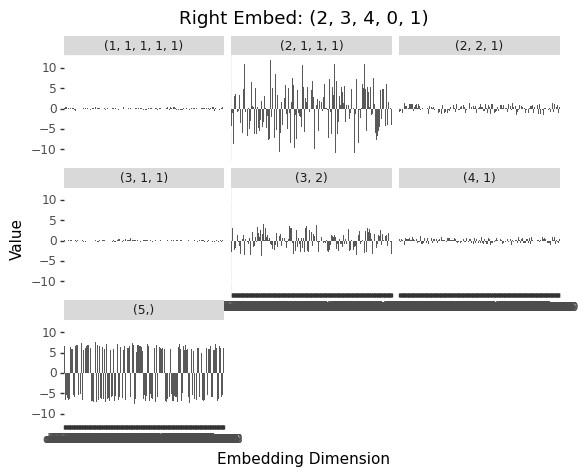

<ggplot: (712074895)>

In [66]:
make_embed_barplot(rembed_df, S5[32], 'Right Embed')

In [71]:
perms = [str(p.sigma) for p in S5]
parities = ['odd' if p.parity else 'even' for p in S5]
conj_class = [str(p.conjugacy_class) for p in S5]
s5_df = pl.DataFrame({'permutation': perms, 'parity': parities, 'conjugacy_class': conj_class})


In [73]:
full_lembed = lembed_df.join(s5_df, on='permutation', how='inner')

In [87]:
df = (
    full_lembed
    .melt(id_vars=['permutation', 'irrep', 'parity', 'conjugacy_class'])
    .pivot(index=['permutation', 'parity', 'conjugacy_class', 'variable'], columns='irrep', values='value')
    .with_columns(pl.col('variable').str.lstrip('dim').str.parse_int(radix=10).alias('embed_dim'))
    
)

df.head(50)

permutation,parity,conjugacy_class,variable,"(1, 1, 1, 1, 1)","(2, 1, 1, 1)","(2, 2, 1)","(3, 1, 1)","(3, 2)","(4, 1)","(5,)",embed_dim
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,i32
"""(0, 1, 2, 3, 4...","""even""","""(1, 1, 1, 1, 1...","""dim0""",-0.156939,-6.842973,0.563898,0.034046,-0.833493,0.327888,-6.635604,0
"""(0, 1, 3, 4, 2...","""even""","""(3, 1, 1)""","""dim0""",-0.156939,-2.63956,1.113845,-0.036829,-2.495334,0.106469,-6.635604,0
"""(0, 1, 4, 2, 3...","""even""","""(3, 1, 1)""","""dim0""",-0.156939,6.966103,0.658711,-0.382375,2.867841,0.188975,-6.635604,0
"""(0, 2, 1, 4, 3...","""even""","""(2, 2, 1)""","""dim0""",-0.156939,-3.973511,-0.737551,-0.003962,-0.472371,0.459028,-6.635604,0
"""(0, 2, 3, 1, 4...","""even""","""(3, 1, 1)""","""dim0""",-0.156939,-9.281008,-1.180313,0.155703,2.233769,0.286669,-6.635604,0
"""(0, 2, 4, 3, 1...","""even""","""(3, 1, 1)""","""dim0""",-0.156939,-1.032383,-0.733263,-0.013796,0.240196,0.58493,-6.635604,0
"""(0, 3, 1, 2, 4...","""even""","""(3, 1, 1)""","""dim0""",-0.156939,-1.071474,1.021688,0.121867,1.217369,0.676228,-6.635604,0
"""(0, 3, 2, 4, 1...","""even""","""(3, 1, 1)""","""dim0""",-0.156939,-6.752255,-0.185064,-0.096213,0.632309,0.494976,-6.635604,0
"""(0, 3, 4, 1, 2...","""even""","""(2, 2, 1)""","""dim0""",-0.156939,0.036093,-0.081979,-0.353553,-2.278354,0.268098,-6.635604,0


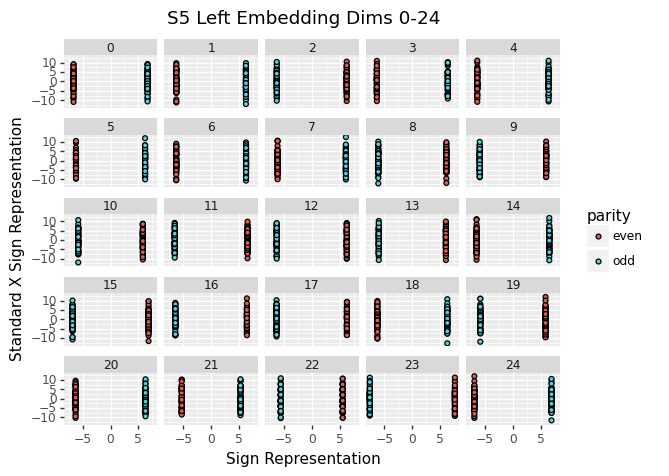

<ggplot: (705149292)>

In [107]:




filtered_df = df.filter(pl.col('conjugacy_class') != '(1, 1, 1, 1, 1)').filter(pl.col('embed_dim') < 25) #.filter(pl.col('embed_dim') > )

(ggplot(
    filtered_df.to_pandas(),
    aes(x='(5,)', y='(2, 1, 1, 1)', fill='parity')) 
 + geom_point() 
 + facet_wrap('~embed_dim', nrow=5)
 + xlab('Sign Representation')
 + ylab('Standard X Sign Representation')
 + ggtitle('S5 Left Embedding Dims 0-24')
)


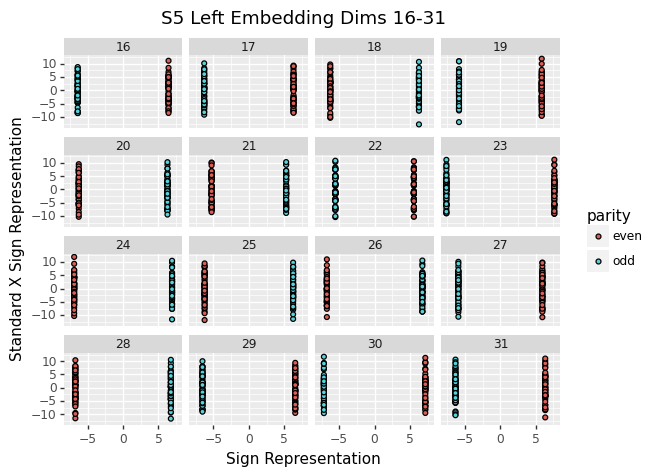

<ggplot: (704915679)>

In [108]:
def make_embed_scatterplot(data, mindim, maxdim):
    filtered_df = data.filter(
        pl.col('conjugacy_class') != '(1, 1, 1, 1, 1)'
    ).filter(pl.col('embed_dim') < maxdim).filter(pl.col('embed_dim') >= mindim)

    return (ggplot(
        filtered_df.to_pandas(),
        aes(x='(5,)', y='(2, 1, 1, 1)', fill='parity')) 
     + geom_point() 
     + facet_wrap('~embed_dim', nrow=4)
     + xlab('Sign Representation')
     + ylab('Standard X Sign Representation')
     + ggtitle(f'S5 Left Embedding Dims {mindim}-{maxdim - 1}')
    )

make_embed_scatterplot(df, 16, 32)

In [111]:
for mindim in range(0, 256, 16):
    plot = make_embed_scatterplot(df, mindim, mindim+16)
    fname = f'dims{mindim}-{mindim+15}.png'
    plot.save(f'plots/lembed_scatter/{fname}')

/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/lembed_scatter/dims0-15.png
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/lembed_scatter/dims16-31.png
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/lembed_scatter/dims32-47.png
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.

In [112]:
out, cache = model.run_with_cache(torch.tensor(0), torch.tensor(0))

In [113]:
x, y = torch.cartesian_prod(torch.arange(0, 120), torch.arange(0, 120)).hsplit(2)
x, y = x.squeeze(), y.squeeze()
out, cache = model.run_with_cache(x, y)

In [114]:
labels = torch.argmax(out, dim=1)

In [115]:
inverse_idx = torch.where(labels == 0)[0]

In [14]:
list(cache.keys())

['hook_lembed', 'hook_rembed', 'hook_linear', 'hook_unembed']

In [117]:
from torch.nn.functional import relu

linear_activations = relu(cache['hook_linear'])


In [162]:
perms, mult_df = make_permutation_dataset(5)

In [164]:
from operator import add
from functools import reduce
#mult_df['permutation_left'].apply(lambda x: reduce(add, [str(i) for i in x]))
#mult_df['permutation_left'].arr.eval(pl.element().cast(str)).arr.join('')

mult_df.columns

['index_left',
 'permutation_left',
 'cycle_rep_left',
 'conjugacy_class_left',
 'parity_left',
 'index_right',
 'perm_right',
 'cycle_rep_right',
 'conjugacy_class_right',
 'parity_right',
 'permutation_target',
 'index_target',
 'conjugacy_class_target']

In [165]:

    
mult_df = mult_df.with_columns([
    pl.col('permutation_left').arr.eval(pl.element().cast(str)).arr.join(''),
    pl.col('perm_right').arr.eval(pl.element().cast(str)).arr.join(''),
    pl.col('permutation_target').arr.eval(pl.element().cast(str)).arr.join(''),
    pl.col('conjugacy_class_left').arr.eval(pl.element().cast(str)).arr.join(''),
    pl.col('conjugacy_class_right').arr.eval(pl.element().cast(str)).arr.join(''),
    pl.col('conjugacy_class_target').arr.eval(pl.element().cast(str)).arr.join('')
])


In [167]:
mult_df.select([pl.col('^perm.*$'), pl.col('^index.*$'), 'parity_left']).head()

permutation_left,perm_right,permutation_target,index_left,index_right,index_target,parity_left
str,str,str,i32,i32,i32,i64
"""01234""","""01234""","""01234""",0,0,0,0
"""01234""","""01342""","""01342""",0,1,1,0
"""01234""","""01423""","""01423""",0,2,2,0
"""01234""","""02143""","""02143""",0,3,3,0
"""01234""","""02314""","""02314""",0,4,4,0


In [174]:
irrep_a = SnIrrep(5, (3, 2))
irrep_b = SnIrrep(5, (5,))


In [187]:
mats1, mats2 = zip(
        *product(
            irrep_a.matrix_tensor().split(1),
            irrep_b.matrix_tensor().split(1))
)

In [190]:
torch.cat(mats1).shape

torch.Size([14400, 5, 5])

In [325]:
from itertools import product
from sngrok.fourier import fft_sum, ift_trace


def _dot(fx, rho):
    return fx * rho

fft_dot = functorch.vmap(_dot, in_dims=(0, 0))

def _fft_sum(fx, rho):
    if rho.dim() == 1:
        return torch.dot(fx, rho)
    else:
        return fft_dot(fx, rho).sum(dim=0)
    
fft_sum = functorch.vmap(_fft_sum, in_dims=(1, None))


def slow_sn_fourier_2d(fn_vals, n):
    all_partitions = generate_partitions(n)
    all_irreps = [SnIrrep(n, p) for p in all_partitions]
    results = {}
    for lirrep, rirrep in product(all_irreps, all_irreps):
        mats1, mats2 = zip(
            *product(
                lirrep.matrix_tensor().split(1),
                rirrep.matrix_tensor().split(1))
        )
        mats = batch_kron(torch.cat(mats1).squeeze(), torch.cat(mats2).squeeze())
        results[(lirrep.shape, rirrep.shape)] = fft_sum(fn_vals.to(torch.float64), mats).squeeze()
    return results



In [326]:
fourier_linear = slow_ft_2d(linear_activations, 5)

In [369]:
import math


def _ift_trace(ft_vals, inv_rep):
    dim = inv_rep.dim()
    if dim < 2:
        return inv_rep * ft_vals
    else:
        dim = inv_rep.shape[0]
        return dim * torch.trace(inv_rep @ ft_vals)

ift_trace = functorch.vmap(_ift_trace, in_dims=(0, None))


def sn_fourier_basis_2d(ft, n):
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    group_order = 1.0 * len(permutations)**2
    all_irreps = {p: SnIrrep(n, p).matrix_representations() for p in all_partitions}
    ift_decomps = []
    for perm1, perm2 in product(permutations, permutations):
        fourier_decomp = []
        for part1, part2 in product(all_partitions, all_partitions):
            inverse_mat1 = torch.asarray(all_irreps[part1][perm1.sigma].T).squeeze()      
            inverse_mat2 = torch.asarray(all_irreps[part2][perm2.sigma].T).squeeze()
            inv_mat = torch.kron(inverse_mat1 , inverse_mat2)
            trace = ift_trace(ft[(part1, part2)], inv_mat).unsqueeze(0)
            fourier_decomp.append(trace)
        ift_decomps.append(torch.cat(fourier_decomp).unsqueeze(0))
    return torch.cat(ift_decomps) / group_order

In [370]:
fourier_decomp_linear = sn_fourier_basis_2d(fourier_linear, 5)

In [373]:
torch.allclose(fourier_decomp_linear.sum(dim=1), linear_activations.to(torch.float64))

True

In [368]:
linear_activations[0]

tensor([2.8553e-01, 0.0000e+00, 3.0106e+00, 1.0924e+00, 0.0000e+00, 3.3487e+00,
        0.0000e+00, 1.0734e+01, 8.0828e+00, 3.0203e-01, 1.0703e+00, 0.0000e+00,
        2.3926e-01, 1.0639e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0063e-02,
        8.4228e-02, 0.0000e+00, 6.0777e-01, 0.0000e+00, 0.0000e+00, 6.3993e+00,
        0.0000e+00, 1.3074e-01, 0.0000e+00, 6.0858e+00, 2.6040e-02, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.2705e+00, 0.0000e+00,
        4.9346e-02, 1.0628e+00, 0.0000e+00, 2.6617e-02, 5.5742e-01, 0.0000e+00,
        7.5691e+00, 0.0000e+00, 0.0000e+00, 4.5477e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.6486e+00, 3.6517e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6365e+00, 1.2684e+01, 0.0000e+00,
        1.5791e+00, 0.0000e+00, 7.0825e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0310e+00, 0.0000e+00,
        4.7852e+00, 4.1936e-01, 0.0000e+

In [279]:
torch.kron(torch.tensor([1., 1.]), torch.tensor([1., 1.]))

tensor([1., 1., 1., 1.])

In [304]:
linear_activations.sum(dim=0)

tensor([ 2002.5645, 16889.8008, 41486.6836,  3106.0728, 36385.3203, 37416.4844,
         5225.4409, 42565.3281, 32504.4629,  4632.6113, 18679.1738,  4103.5913,
         2040.3362,  1441.2042, 31939.9258, 29350.5586, 34611.5898,  5440.6323,
        31948.8594, 19352.7012,  5056.4917, 40087.6641, 15516.7031, 39302.0547,
        34198.3047,  1792.4534, 18487.9805, 28358.4121,  2147.7690, 38083.6992,
        19725.6934, 32620.2559, 36620.3945, 21484.6016, 23453.6152, 35826.2031,
         4913.1294,  5688.1763,  5371.0566,  3919.8328,  4118.9985, 37897.3555,
        30426.0410,   319.8083,  5608.2632, 16838.2969, 11643.4316,  2007.1553,
         9240.8018, 35508.3555, 28398.7188, 14736.1875, 39205.1680, 17489.4160,
        18814.2637, 29206.3398, 16751.7051, 18263.1094, 36001.2422, 35737.9766,
        18144.2344, 19300.8496, 39658.2539,  4164.7178,  3482.5115,  4415.4248,
        29284.1504,  3098.1777,  5169.4272, 15484.0273, 16169.8291, 18555.4453,
        16731.8105,  1991.2312, 33241.26

In [275]:
v = fourier_linear[((1, 1, 1, 1, 1), (5,))]


False


In [273]:
w1

tensor([ 2002.5645, 16889.8001, 41486.6863,  3106.0726, 36385.3198, 37416.4848,
         5225.4414, 42565.3304, 32504.4639,  4632.6111, 18679.1730,  4103.5911,
         2040.3363,  1441.2043, 31939.9262, 29350.5603, 34611.5912,  5440.6324,
        31948.8595, 19352.6999,  5056.4919, 40087.6618, 15516.7033, 39302.0578,
        34198.3041,  1792.4534, 18487.9801, 28358.4134,  2147.7690, 38083.6964,
        19725.6935, 32620.2555, 36620.3959, 21484.6013, 23453.6155, 35826.2076,
         4913.1295,  5688.1761,  5371.0569,  3919.8327,  4118.9988, 37897.3561,
        30426.0420,   319.8083,  5608.2628, 16838.2963, 11643.4315,  2007.1552,
         9240.8015, 35508.3559, 28398.7158, 14736.1878, 39205.1707, 17489.4167,
        18814.2644, 29206.3397, 16751.7051, 18263.1085, 36001.2409, 35737.9782,
        18144.2350, 19300.8486, 39658.2539,  4164.7174,  3482.5114,  4415.4247,
        29284.1520,  3098.1778,  5169.4272, 15484.0258, 16169.8295, 18555.4441,
        16731.8094,  1991.2313, 33241.26

In [311]:
act_power = (linear_activations**2).mean(dim=0)
act_power[0:5]

tensor([ 0.0604,  4.2823, 25.9785,  0.1434, 25.4651])

In [327]:
print(linear_activations.sum(dim=0)[0:5])
fourier_linear[((1, 1, 1, 1, 1), (1, 1, 1, 1, 1))][0:5]

tensor([ 2002.5645, 16889.8008, 41486.6836,  3106.0728, 36385.3203])


tensor([ 2002.5645, 16889.8001, 41486.6863,  3106.0726, 36385.3198],
       dtype=torch.float64)

In [360]:

def _trace(ft_vals):
    dim = ft_vals.dim()
    if dim < 2:
        return  ft_vals**2
    else:
        return torch.trace(ft_vals)
    
def _frob_norm(ft_vals):
    dim = ft_vals.dim()
    if dim < 2:
        return ft_vals**2
    else:
        dim = ft_vals.shape[0]
        return dim * torch.trace(ft_vals.T @ ft_vals)

frob = functorch.vmap(_frob_norm, in_dims=0)

total = torch.zeros(128)
act_power = (linear_activations**2).mean(dim=0)
irrep_powers = {}


def calc_power(ft):
    return {k: frob(v)/(14400**2) for k, v in ft.items()}

for key, values in fourier_linear.items():
    
    t = frob(values) / (14400.0**2)
    #t2 = frob(v2) / (14400)
    total += t
    #print(f'{key}: {(act_power - t).mean}')
    running = act_power - total
    print(f'Max error {torch.max(running)}')
#ft_power = calc_power(fourier_linear)


Max error 19.22640037536621
Max error 19.226362228393555
Max error 19.226299285888672
Max error 19.22626495361328
Max error 19.2262020111084
Max error 19.226163864135742
Max error 12.779397964477539
Max error 12.779322624206543
Max error 12.779322624206543
Max error 12.779321670532227
Max error 12.77932071685791
Max error 12.779319763183594
Max error 12.779319763183594
Max error 12.779244422912598
Max error 12.77906322479248
Max error 12.779062271118164
Max error 12.779060363769531
Max error 12.779059410095215
Max error 12.779057502746582
Max error 12.779056549072266
Max error 12.778876304626465
Max error 12.778738021850586
Max error 12.778738021850586
Max error 12.77873706817627
Max error 12.778736114501953
Max error 12.778735160827637
Max error 12.778735160827637
Max error 12.778596878051758
Max error 12.778428077697754
Max error 12.778427124023438
Max error 12.778425216674805
Max error 12.778424263000488
Max error 12.778422355651855
Max error 12.778421401977539
Max error 12.77825260

In [357]:
ft_power = calc_power(fourier_linear)

In [375]:
collect = []
for k, v in ft_power.items():
    collect.append(v[2].unsqueeze(0))
    print(f'{k}: {100 * v[2] / act_power[2]}')
first_dim = torch.cat(collect)

((1, 1, 1, 1, 1), (1, 1, 1, 1, 1)): 31.950531187336285
((1, 1, 1, 1, 1), (2, 1, 1, 1)): 26.358842206750733
((1, 1, 1, 1, 1), (2, 2, 1)): 0.0003505269320973137
((1, 1, 1, 1, 1), (3, 1, 1)): 0.00028747935846427475
((1, 1, 1, 1, 1), (3, 2)): 0.0002590787899671951
((1, 1, 1, 1, 1), (4, 1)): 8.187026157321872e-05
((1, 1, 1, 1, 1), (5,)): 3.328057625370244e-06
((2, 1, 1, 1), (1, 1, 1, 1, 1)): 26.861645154821634
((2, 1, 1, 1), (2, 1, 1, 1)): 14.82777828639358
((2, 1, 1, 1), (2, 2, 1)): 6.310364526664106e-05
((2, 1, 1, 1), (3, 1, 1)): 6.343405234593812e-05
((2, 1, 1, 1), (3, 2)): 5.5663894535187635e-05
((2, 1, 1, 1), (4, 1)): 2.462775202538498e-05
((2, 1, 1, 1), (5,)): 1.0219209049459854e-06
((2, 2, 1), (1, 1, 1, 1, 1)): 9.646280389965918e-07
((2, 2, 1), (2, 1, 1, 1)): 2.2730671069841458e-07
((2, 2, 1), (2, 2, 1)): 5.32951095150145e-09
((2, 2, 1), (3, 1, 1)): 4.535406328559111e-09
((2, 2, 1), (3, 2)): 4.09541878199529e-09
((2, 2, 1), (4, 1)): 1.200916287621017e-09
((2, 2, 1), (5,)): 1.00870870

In [359]:
print(first_dim.shape)
torch.cumsum(first_dim, 0)

torch.Size([49])


tensor([ 8.3003, 15.1479, 15.1480, 15.1481, 15.1481, 15.1482, 15.1482, 22.1264,
        25.9785, 25.9785, 25.9785, 25.9785, 25.9785, 25.9785, 25.9785, 25.9785,
        25.9785, 25.9785, 25.9785, 25.9785, 25.9785, 25.9785, 25.9785, 25.9785,
        25.9785, 25.9785, 25.9785, 25.9785, 25.9785, 25.9785, 25.9785, 25.9785,
        25.9785, 25.9785, 25.9785, 25.9785, 25.9785, 25.9785, 25.9785, 25.9785,
        25.9785, 25.9785, 25.9785, 25.9785, 25.9785, 25.9785, 25.9785, 25.9785,
        25.9785], dtype=torch.float64)

In [351]:
(linear_activations[:, 2]) ** 2).sum()

tensor(41486.6836)

In [353]:
(fourier_linear[((1, 1, 1, 1, 1), (1, 1, 1, 1, 1))][2] ** 2) / (14400**2)

tensor(8.3003, dtype=torch.float64)

In [376]:
fourier_decomp_linear.sum(dim=1)[0]

tensor([ 2.8553e-01, -1.6493e-16,  3.0106e+00,  1.0924e+00, -4.4409e-16,
         3.3487e+00,  1.5060e-16,  1.0734e+01,  8.0828e+00,  3.0203e-01,
         1.0703e+00, -1.8872e-16,  2.3926e-01,  1.0639e-01, -9.1723e-16,
         1.0051e-16,  9.9351e-16,  5.0063e-02,  8.4228e-02, -1.1857e-16,
         6.0777e-01, -3.2246e-16,  1.5558e-16,  6.3993e+00, -2.0479e-16,
         1.3074e-01,  1.6604e-16,  6.0858e+00,  2.6040e-02, -1.4648e-15,
         3.3348e-16, -1.3791e-16, -7.7289e-16,  6.4836e-16,  5.2705e+00,
         3.6684e-16,  4.9346e-02,  1.0628e+00,  6.8108e-17,  2.6617e-02,
         5.5742e-01, -2.0538e-16,  7.5691e+00,  1.8431e-17, -1.1577e-16,
         4.5477e+00,  5.4210e-19, -3.0276e-17,  3.3664e-16,  2.6486e+00,
         3.6517e+00,  6.7403e-16,  9.7519e-16,  1.0214e-16,  9.8687e-18,
        -9.3014e-16,  1.2394e-15,  2.6365e+00,  1.2684e+01, -9.5596e-16,
         1.5791e+00,  5.6260e-16,  7.0825e+00,  3.2011e-17,  1.6736e-17,
         1.8788e-16,  1.6552e-15, -9.4813e-17, -4.1

In [377]:

def fourier_basis_2d_to_df(tensor, n):
    group_order, num_irreps, fn_dim = tensor.shape
    partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    perm_pairs = list(product(permutations, permutations))
    partition_pairs = list(product(partitions, partitions))
    assert len(perm_pairs) == group_order, f'{len(perm_pairs)} != {group_order}'
    assert len(partition_pairs) == num_irreps, f'{len(partition_pairs)} != {num_irreps}'
    
    lparts, rparts = zip(*[(str(p1), str(p2)) for p1, p2 in partition_pairs])
    lperm_col, rperm_col = [], []
    lpart_col, rpart_col = [], []
    
    for perm1, perm2 in perm_pairs:
        lpart_col.extend(lparts)
        rpart_col.extend(rparts)
        lperm_col.extend([str(perm1.sigma)] * num_irreps)
        rperm_col.extend([str(perm2.sigma)] * num_irreps)
        
    long_values = tensor.reshape((-1, fn_dim))
    #group_col= []
    #for s in permutations:
    #    group_col += [str(s.sigma)] * num_irreps
    #part_col = [str(p) for p in all_partitions] * group_order
    assert len(lperm_col) == len(rperm_col)
    assert len(lperm_col) == len(lpart_col)
    assert len(lpart_col) == len(rpart_col)
    assert len(lpart_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({
        'permutation_left': lperm_col,
        'permutation_right': rperm_col,
        'irrep_left': lpart_col,
        'irrep_right': rpart_col
    })
    return pl.concat([sn_metadata, val_data], how='horizontal')


In [378]:
linear_df = fourier_basis_2d_to_df(fourier_decomp_linear, 5)

In [379]:
linear_df.head(49)

permutation_left,permutation_right,irrep_left,irrep_right,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,...,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,...,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...","""(1, 1, 1, 1, 1...",0.139067,1.172903,2.88102,0.215699,2.526758,2.598367,0.362878,2.955926,2.257254,0.321709,1.297165,0.284972,0.14169,0.100084,2.21805,2.038233,2.403583,0.377822,2.218671,1.343937,0.351145,2.783865,1.077549,2.72931,2.374882,0.124476,1.283888,1.969334,0.149151,2.644701,1.36984,2.265296,2.543083,...,1.162091,1.507115,0.302025,2.430308,1.263502,0.275424,2.410601,2.53911,0.096634,1.304968,0.138121,2.493952,0.144215,0.832942,2.354053,1.098959,0.271395,0.028928,2.40785,0.107705,1.106069,2.266395,0.780908,2.05811,0.37892,2.673721,1.084741,1.108648,2.629597,0.590533,2.579675,0.119867,1.234337,2.363341,1.148844,0.012389,2.335468
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...","""(2, 1, 1, 1)""",-0.029646,-0.000482,-0.838412,0.018278,0.005665,3.945002,-0.092522,4.488228,0.806278,-0.075393,-0.000332,0.04894,-0.028628,-0.008626,-1.712585,1.114959,-0.54538,-0.102239,3.901111,-1.343732,0.077018,-2.78447,-0.71063,1.325728,-1.763194,-0.028078,-0.00032,-0.266624,-0.070427,-1.889991,-1.370325,-0.369791,-2.542664,...,0.000833,-1.516029,-0.087901,3.787265,-1.254554,-0.054646,-2.410592,-0.006499,-0.002495,0.00085,-0.02508,3.890419,-0.04381,0.473067,3.662121,0.000217,0.051907,0.002479,-1.790906,-0.018908,-0.000463,-0.301152,0.098224,-1.258187,0.069091,-0.762324,-0.002903,-0.000359,1.281884,0.045414,4.021144,-0.025245,0.000034,1.243963,-0.002977,-0.004486,0.955839
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...","""(2, 2, 1)""",0.014991,0.000098,-0.005806,-0.045872,-0.004406,-0.000515,0.112877,-0.000233,0.001822,0.102913,0.000238,-0.192773,-0.010097,0.007452,0.003413,-0.000366,0.001441,0.118818,0.006724,0.00051,-0.235957,0.000285,0.001244,0.000568,0.000472,0.009972,-0.000573,-0.011981,-0.01206,0.004497,-0.001258,-0.004773,0.000109,...,-0.001056,-0.001213,-0.264332,-0.000273,-0.002572,-0.027143,-0.000139,0.00235,0.012029,-0.001281,0.006806,-0.000457,-0.001226,-0.000099,-0.000297,-0.000119,-0.184913,-0.001365,0.000714,0.007043,-0.000269,0.002108,-0.136068,-0.001421,0.434677,-0.005121,-0.001809,-0.000271,-0.000376,0.016354,-0.000072,0.00025,0.000215,-0.000107,-0.001718,-0.002662,-0.008592
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...","""(3, 1, 1)""",0.006323,0.000625,0.004617,0.001682,-0.005867,0.000401,0.009724,-0.000402,-0.002707,0.011461,0.000091,-0.007052,-0.002818,0.011988,0.00156,-0.002956,-0.001528,0.00759,0.044737,-0.001146,-0.009991,-0.00005,-0.002449,-0.001044,-0.000463,0.001589,-0.00024,0.034481,-0.000228,-0.000831,0.004133,0.002622,-0.001289,...,0.000378,0.013101,0.023764,0.000934,0.003001,0.022651,0.000171,0.010325,0.010217,0.000272,0.006637,0.000953,-0.016738,-0.001249,0.002117,-0.000311,-0.006751,0.000319,-0.000364,-0.006884,-0.0005,-0.001478,0.000275,0.002327,-0.008402,0.004353,0.000522,0.000182,-0.000636,-0.015144,0.001819,0.005878,-0.000378,-0.00241,-0.000018,-0.000106,0.003462
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(1, 1, 1, 1, 1...","""(3, 2)""",0.002314,-0.605052,-0.001415,0.214765,-0.004721,-0.000367,-0.005035,0.000351,-0.00295,-0.002625,-0.668986,0.00638,-0.006338,-0.009513,-0.004152,0.000041,0.00034

In [407]:
{col: int(col[3:]) for col in linear_df.columns if col.startswith('dim')}

{'dim0': 0,
 'dim1': 1,
 'dim2': 2,
 'dim3': 3,
 'dim4': 4,
 'dim5': 5,
 'dim6': 6,
 'dim7': 7,
 'dim8': 8,
 'dim9': 9,
 'dim10': 10,
 'dim11': 11,
 'dim12': 12,
 'dim13': 13,
 'dim14': 14,
 'dim15': 15,
 'dim16': 16,
 'dim17': 17,
 'dim18': 18,
 'dim19': 19,
 'dim20': 20,
 'dim21': 21,
 'dim22': 22,
 'dim23': 23,
 'dim24': 24,
 'dim25': 25,
 'dim26': 26,
 'dim27': 27,
 'dim28': 28,
 'dim29': 29,
 'dim30': 30,
 'dim31': 31,
 'dim32': 32,
 'dim33': 33,
 'dim34': 34,
 'dim35': 35,
 'dim36': 36,
 'dim37': 37,
 'dim38': 38,
 'dim39': 39,
 'dim40': 40,
 'dim41': 41,
 'dim42': 42,
 'dim43': 43,
 'dim44': 44,
 'dim45': 45,
 'dim46': 46,
 'dim47': 47,
 'dim48': 48,
 'dim49': 49,
 'dim50': 50,
 'dim51': 51,
 'dim52': 52,
 'dim53': 53,
 'dim54': 54,
 'dim55': 55,
 'dim56': 56,
 'dim57': 57,
 'dim58': 58,
 'dim59': 59,
 'dim60': 60,
 'dim61': 61,
 'dim62': 62,
 'dim63': 63,
 'dim64': 64,
 'dim65': 65,
 'dim66': 66,
 'dim67': 67,
 'dim68': 68,
 'dim69': 69,
 'dim70': 70,
 'dim71': 71,
 'dim72': 72

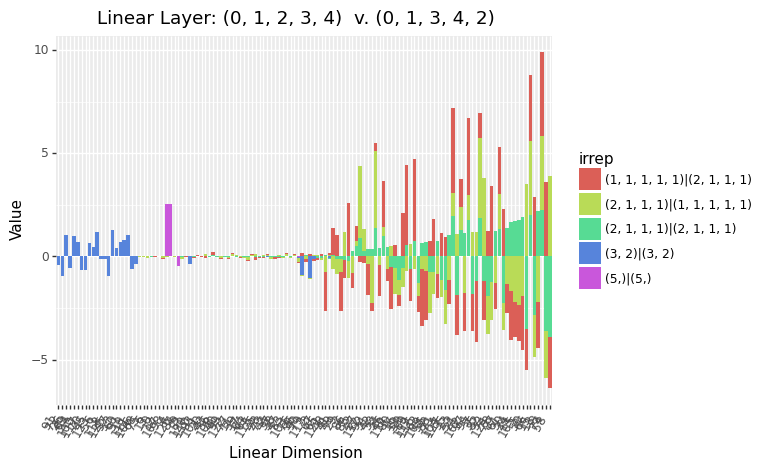

<ggplot: (716922382)>

In [439]:
from plotnine import theme, element_text
import numpy as np


def make_embed_barplot_2d(data, lperm, rperm, irreps, title_prefix):
    df = data.filter(
          (pl.col('permutation_left') == str(lperm.sigma)) 
        & (pl.col('permutation_right') == str(rperm.sigma))
        #& ((pl.col('irrep_left') == rep[0]) & (pl.col('irrep_right') == rep[1]))
    ).rename(
        {col: col[3:] for col in linear_df.columns if col.startswith('dim')}
    ).melt(
        id_vars=['permutation_left', 'permutation_right','irrep_left', 'irrep_right']
    ).with_columns(
        [pl.col('variable').str.parse_int(radix=10),
        (pl.col('irrep_left') + '|' + pl.col('irrep_right')).alias('irrep')]
    ).filter(
        pl.col('irrep').is_in(irreps)
    ).to_pandas()
    return (
        ggplot(df, aes(x='reorder(factor(variable), np.abs(value))', y='value', fill='irrep')) 
        + geom_col()
        #+ facet_wrap('~variable_group') 
        + xlab('Linear Dimension')
        + ylab('Value')
        + ggtitle(f'{title_prefix}: {str(lperm.sigma)}  v. {rperm.sigma}')
        + theme(axis_text_x=element_text(rotation=60, hjust=1))
    )

S5 = Permutation.full_group(5)

make_embed_barplot_2d(linear_df, S5[0], S5[1], [
    "(2, 1, 1, 1)|(2, 1, 1, 1)",
    "(3, 2)|(3, 2)",
    "(5,)|(5,)",
    "(2, 1, 1, 1)|(1, 1, 1, 1, 1)",
    "(1, 1, 1, 1, 1)|(2, 1, 1, 1)"], 'Linear Layer'
)

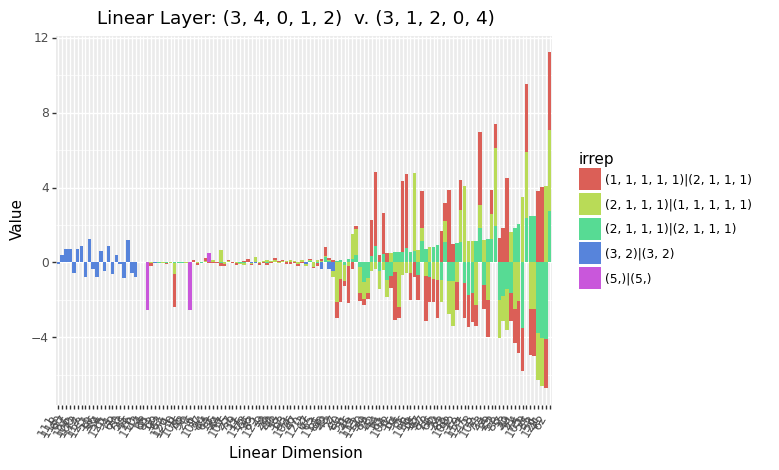

<ggplot: (718066866)>

In [440]:
make_embed_barplot_2d(linear_df, S5[45], S5[100], [
    "(2, 1, 1, 1)|(2, 1, 1, 1)",
    "(5,)|(5,)",
    "(3, 2)|(3, 2)",
    "(2, 1, 1, 1)|(1, 1, 1, 1, 1)",
    "(1, 1, 1, 1, 1)|(2, 1, 1, 1)"], 'Linear Layer'
)

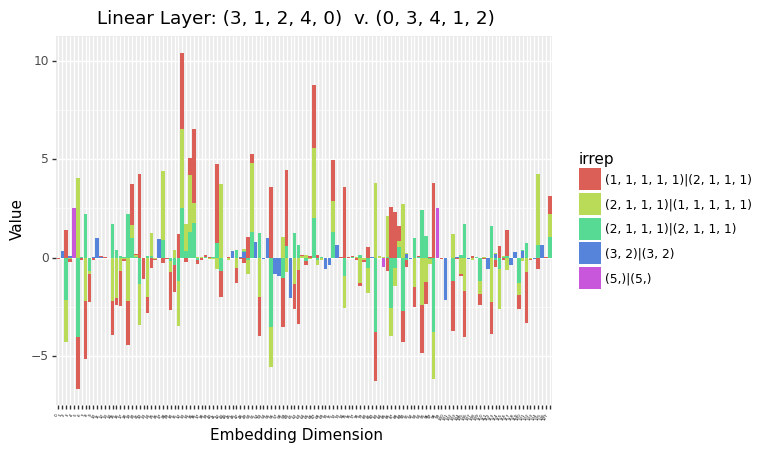

<ggplot: (705528941)>

In [421]:
make_embed_barplot_2d(linear_df, S5[40], S5[8], [
    "(2, 1, 1, 1)|(2, 1, 1, 1)",
    "(5,)|(5,)",
    "(3, 2)|(3, 2)",
    "(2, 1, 1, 1)|(1, 1, 1, 1, 1)",
    "(1, 1, 1, 1, 1)|(2, 1, 1, 1)"], 'Linear Layer'
)

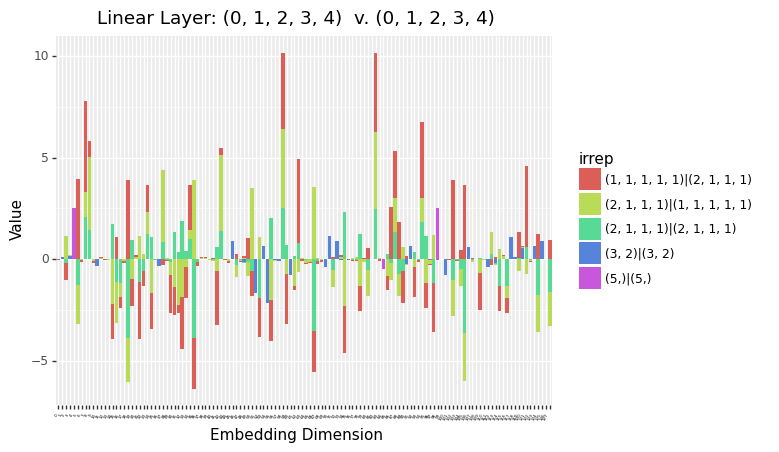

<ggplot: (716922706)>

In [422]:
make_embed_barplot_2d(linear_df, S5[0], S5[0], [
    "(2, 1, 1, 1)|(2, 1, 1, 1)",
    "(5,)|(5,)",
    "(3, 2)|(3, 2)",
    "(2, 1, 1, 1)|(1, 1, 1, 1, 1)",
    "(1, 1, 1, 1, 1)|(2, 1, 1, 1)"], 'Linear Layer'
)

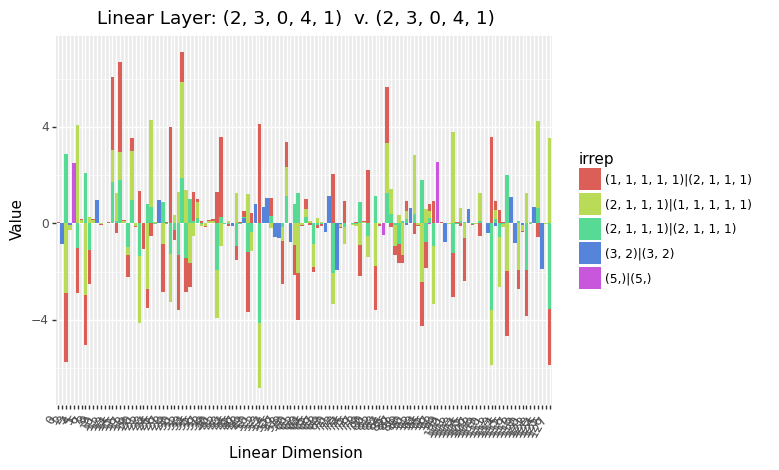

<ggplot: (706784746)>

In [430]:
make_embed_barplot_2d(linear_df, S5[90], S5[90], [
    "(2, 1, 1, 1)|(2, 1, 1, 1)",
    "(5,)|(5,)",
    "(3, 2)|(3, 2)",
    "(2, 1, 1, 1)|(1, 1, 1, 1, 1)",
    "(1, 1, 1, 1, 1)|(2, 1, 1, 1)"], 'Linear Layer'
)

In [450]:
from itertools import chain
(linear_df
    .filter((pl.col('irrep_left') == "(3, 2)") & (pl.col('irrep_right') == "(3, 2)"))
    .groupby(['irrep_left', 'irrep_right'])
    .agg([pl.col(col).abs().mean() for col in linear_df.columns if col.startswith('dim')])
)

irrep_left,irrep_right,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,dim34,...,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,...,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""(3, 2)""","""(3, 2)""",0.002185,0.63279,0.000021,0.05991,0.000804,0.000018,0.001062,0.000032,0.000108,0.001133,0.69984,0.001029,0.002362,0.001571,0.000092,0.000069,0.000027,0.001344,0.000324,0.000027,0.000952,0.000028,0.000133,0.000019,0.000017,0.00216,0.692815,0.000188,0.002005,0.000019,0.00019,0.000093,0.000033,0.000124,0.000099,...,0.627189,0.000111,0.00132,0.000022,0.000136,0.015654,0.000017,0.000804,0.001426,0.704339,0.002111,0.000031,0.00192,0.000034,0.000028,0.592847,0.000929,0.000936,0.000016,0.001916,0.596769,0.000051,0.272,0.000083,0.000919,0.000026,0.585569,0.598267,0.000015,0.240092,0.00002,0.001776,0.666098,0.000064,0.620237,0.000527,0.000019


In [468]:
irrep32_stats = (linear_df
    .filter(
        (pl.col('irrep_left') == "(3, 2)") & (pl.col('irrep_right') == "(3, 2)"))
        #& ((pl.col('irrep_left') == rep[0]) & (pl.col('irrep_right') == rep[1])))
 .melt(
        id_vars=['permutation_left', 'permutation_right','irrep_left', 'irrep_right'])
    .groupby('variable')
    .agg([
        pl.col('value').abs().mean().alias('mean_abs'),
        pl.col('value').min().alias('min'),
        pl.col('value').quantile(0.1).alias('quantile_10'),
        pl.col('value').quantile(0.25).alias('quantile_25'),
        pl.col('value').quantile(0.5).alias('quantile_50'),
        pl.col('value').quantile(0.75).alias('quantile_75'),
        pl.col('value').quantile(0.9).alias('quantile_90'),
        pl.col('value').quantile(0.99).alias('quantile_99'),
        pl.col('value').min().alias('max').alias('max')
    ])
 .filter(
     (pl.col('quantile_25') < -0.1) | (pl.col('quantile_75') > 0.1)
 )
)
irrep32_stats

variable,mean_abs,min,quantile_10,quantile_25,quantile_50,quantile_75,quantile_90,quantile_99,max
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""dim45""",0.631129,-2.013292,-0.856705,-0.567945,0.088203,0.635746,0.924662,1.169328,-2.013292
"""dim106""",0.592847,-1.892477,-0.804554,-0.533863,0.08193,0.59744,0.868194,1.099099,-1.892477
"""dim54""",0.705094,-2.249933,-0.956579,-0.634535,0.097124,0.710472,1.032517,1.306929,-2.249933
"""dim123""",0.666098,-2.125177,-0.90462,-0.599912,0.092526,0.671081,0.975927,1.234306,-2.125177
"""dim91""",0.627189,-2.001252,-0.85138,-0.564765,0.086804,0.632086,0.918454,1.162322,-2.001252
"""dim111""",0.596769,-1.904519,-0.810456,-0.537482,0.082584,0.601324,0.874525,1.106176,-1.904519
"""dim53""",0.65535,-2.091372,-0.889571,-0.590287,0.090856,0.660143,0.96005,1.214603,-2.091372
"""dim118""",0.598267,-1.908986,-0.812625,-0.53906,0.082751,0.603071,0.876852,1.108735,-1.908986
"""dim56""",0.627768,-2.00312,-0.852605,-0.565707,0.086805,0.632819,0.920055,1.163401,-2.00312


In [467]:
irrep2111_stats = (linear_df
    .filter(
        (pl.col('irrep_left') == "(2, 1, 1, 1)") & (pl.col('irrep_right') == "(2, 1, 1, 1)"))
        #& ((pl.col('irrep_left') == rep[0]) & (pl.col('irrep_right') == rep[1])))
 .melt(
        id_vars=['permutation_left', 'permutation_right','irrep_left', 'irrep_right'])
    .groupby('variable')
    .agg([
        pl.col('value').abs().mean().alias('mean_abs'),
        pl.col('value').min().alias('min'),
        pl.col('value').quantile(0.1).alias('quantile_10'),
        pl.col('value').quantile(0.25).alias('quantile_25'),
        pl.col('value').quantile(0.5).alias('quantile_50'),
        pl.col('value').quantile(0.75).alias('quantile_75'),
        pl.col('value').quantile(0.9).alias('quantile_90'),
        pl.col('value').quantile(0.99).alias('quantile_99'),
        pl.col('value').min().alias('max').alias('max')
    ])
 .filter(
     (pl.col('quantile_25') < -0.1) | (pl.col('quantile_75') > 0.1)

)
irrep2111_stats

variable,mean_abs,min,quantile_10,quantile_25,quantile_50,quantile_75,quantile_90,quantile_99,max
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""dim61""",0.842896,-2.262662,-1.256538,-0.714883,0.171612,0.820378,1.258235,1.331803,-2.262662
"""dim14""",1.310528,-3.349362,-1.825569,-1.285323,0.165881,1.274789,1.778997,2.218057,-3.349362
"""dim64""",0.133328,-0.378019,-0.178974,-0.116271,0.008991,0.110065,0.179477,0.241855,-0.378019
"""dim55""",1.057959,-3.557842,-1.432269,-0.735569,0.173783,0.994193,1.316529,2.028835,-3.557842
"""dim36""",0.170133,-0.655291,-0.215298,-0.122903,0.038422,0.148837,0.25223,0.365912,-0.655291
"""dim18""",1.145945,-3.898365,-1.507076,-0.727659,0.123433,0.914155,1.482697,2.222391,-3.898365
"""dim127""",1.291362,-3.645575,-1.735891,-1.131895,0.078057,1.062074,1.73396,2.337208,-3.645575
"""dim16""",1.32927,-3.747942,-1.787156,-1.166048,0.077707,1.099422,1.788383,2.402922,-3.747942
"""dim21""",1.538614,-4.344777,-2.068454,-1.347537,0.094879,1.260526,2.064849,2.783829,-4.344777


In [471]:
dims2111 = irrep2111_stats['variable'].to_list()
dims32 = irrep32_stats['variable'].to_list()

In [473]:
for dim in dims32:
    if dim in dims2111:
        print(dim)

In [477]:
set(dims32).intersection(set(dims2111))

set()

In [483]:
acts = linear_df.filter((pl.col('irrep_left') == "(3, 2)") & (pl.col('irrep_right') == "(3, 2)")).select(dims32)
acts.cor()

AttributeError: 'DataFrame' object has no attribute 'cor'

In [484]:
acts.pearson_corr()

dim45,dim106,dim54,dim123,dim91,dim111,dim53,dim118,dim56,dim26,dim100,dim60,dim10,dim51,dim120,dim1,dim113,dim70,dim125,dim117,dim72,dim57,dim90,dim69,dim48
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,0.040017,-0.200085,-0.199993,0.040033,-0.199993,-0.199852,0.039991,-0.200018,0.039987,0.040015,0.040003,0.039982,-0.200124,0.089661,0.040001,-0.190598,-0.200257,0.040012,-0.200185,0.040029,-0.200051,-0.190381,-0.199905,0.093514
0.040017,1.0,-0.199954,0.039985,1.0,-0.200041,0.03998,-0.199848,0.039945,0.039947,-0.199889,-0.199815,0.039935,-0.199976,-0.384072,-0.199862,0.095947,0.040007,0.039956,0.039995,0.039963,0.039965,0.093932,-0.200005,-0.191484
-0.200085,-0.199954,1.0,0.039994,-0.199998,0.039999,0.03996,0.039977,-0.19992,0.039957,-0.199889,-0.199876,0.039962,1.0,-0.384279,0.039984,-0.191002,-0.199946,0.039941,-0.199897,0.039956,-0.199958,-0.189514,0.039975,0.095808
-0.199993,0.039985,0.039994,1.0,0.039999,-0.199935,1.0,0.039991,0.040006,-0.20005,-0.20008,-0.200033,-0.200031,0.040002,0.111639,0.039995,-0.190448,0.040022,-0.200118,0.040013,-0.200182,0.040004,-0.191333,-0.199965,-0.184561
0.040033,1.0,-0.199998,0.039999,1.0,-0.200087,0.039993,-0.199879,0.03996,0.039955,-0.199904,-0.19983,0.039944,-0.20002,-0.384023,-0.199893,0.095944,0.040015,0.03996,0.040003,0.039967,0.039979,0.093927,-0.200051,-0.191447
-0.199993,-0.200041,0.039999,-0.199935,-0.200087,1.0,-0.199946,-0.199951,0.039976,0.039984,0.040002,0.039977,0.039963,0.040013,0.088855,-0.199971,0.095732,0.040091,0.040043,0.040074,0.040052,0.039994,0.094326,1.0,-0.186757
-0.199852,0.03998,0.03996,1.0,0.039993,-0.199946,1.0,0.039998,0.039981,-0.20008,-0.200045,-0.199998,-0.200061,0.039968,0.111645,0.040002,-0.190492,0.039992,-0.200109,0.039983,-0.200173,0.039979,-0.191383,-0.199976,-0.184571
0.039991,-0.199848,0.039977,0.039991,-0.199879,-0.199951,0.039998,1.0,-0.19988,-0.199928,0.039971,0.039951,-0.199849,0.039979,0.071885,1.0,0.095749,0.040002,0.039986,0.04,0.039986,-0.199939,0.09398,-0.199994,-0.189454
-0.200018,0.039945,-0.19992,0.040006,0.03996,0.039976,0.039981,-0.19988,1.0,-0.199907,0.039969,0.039962,-0.199902,-0.199908,0.071786,-0.199913,-0.190668,-0.199914,0.039965,-0.199914,0.039973,1.0,-0.18957,0.039968,0.094844


In [485]:
! pip3 install networkx[default]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.4 MB/s eta 0:00:00m eta 0:00:010:00:01

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [496]:
from operator import mul

x = (2, 4)
mul(*x)

8

In [497]:
import numpy as np

corr = acts.pearson_corr()
# keep only upper triangle elements (excluding diagonal elements)
mask_keep = np.triu(np.ones(corr.shape), k=1).astype('bool').reshape(mul(*corr.shape))
# melt (unpivot) the dataframe and apply mask
#mask_keep


In [502]:
corr_cols = pl.Series('row_dims', corr.columns)
long_corr = corr.with_columns(corr_cols).melt(id_vars='row_dims', variable_name='col_dims', value_name='corr')
long_corr = long_corr.filter(mask_keep)

In [509]:
import networkx as nx

cutoff = 0.05
edges = long_corr.filter(pl.col('corr') >= cutoff).select(['row_dims', 'col_dims']).rows()
g = nx.from_edgelist(edges)

ls_cliques = []
for clique in nx.algorithms.find_cliques(g):
    ls_cliques.append(clique)

# result
ls_cliques

[['dim60', 'dim100'],
 ['dim120', 'dim125', 'dim72'],
 ['dim120', 'dim118', 'dim113', 'dim90', 'dim1'],
 ['dim120', 'dim123', 'dim53'],
 ['dim120', 'dim48', 'dim45'],
 ['dim120', 'dim48', 'dim113', 'dim90'],
 ['dim120', 'dim48', 'dim57', 'dim56'],
 ['dim120', 'dim48', 'dim117', 'dim70'],
 ['dim120', 'dim69', 'dim113', 'dim111', 'dim90'],
 ['dim120', 'dim26', 'dim10'],
 ['dim91', 'dim113', 'dim90', 'dim106'],
 ['dim54', 'dim51', 'dim48']]

In [517]:
(linear_df
 .select(['permutation_left', 'permutation_right', 'irrep_left', 'irrep_right', 'dim120', 'dim48'])
 .join(s5_df.select(['permutation', 'conjugacy_class']).rename({'conjugacy_class': 'conjugacy_class_left'}), left_on='permutation_left', right_on='permutation', how='inner')
 .join(s5_df.select(['permutation', 'conjugacy_class']).rename({'conjugacy_class': 'conjugacy_class_right'}), left_on='permutation_right', right_on='permutation', how='inner')
 .filter((pl.col('irrep_left') == "(3, 2)") & (pl.col('irrep_right') == "(3, 2)"))
 #.select(['conjugacy_class', 'dim120', 'dim48'])
 #.melt(id_vars='conjugacy_class', variable_name='activations')
).head()

permutation_left,permutation_right,irrep_left,irrep_right,dim120,dim48,conjugacy_class_left,conjugacy_class_right
str,str,str,str,f64,f64,str,str
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""(3, 2)""","""(3, 2)""",0.55855,-0.128564,"""(1, 1, 1, 1, 1...","""(1, 1, 1, 1, 1..."
"""(0, 1, 2, 3, 4...","""(0, 1, 3, 4, 2...","""(3, 2)""","""(3, 2)""",-0.376262,-0.083119,"""(1, 1, 1, 1, 1...","""(3, 1, 1)"""
"""(0, 1, 2, 3, 4...","""(0, 1, 4, 2, 3...","""(3, 2)""","""(3, 2)""",-0.235828,0.211014,"""(1, 1, 1, 1, 1...","""(3, 1, 1)"""
"""(0, 1, 2, 3, 4...","""(0, 2, 1, 4, 3...","""(3, 2)""","""(3, 2)""",0.430436,0.081328,"""(1, 1, 1, 1, 1...","""(2, 2, 1)"""
"""(0, 1, 2, 3, 4...","""(0, 2, 3, 1, 4...","""(3, 2)""","""(3, 2)""",-0.606005,-0.043229,"""(1, 1, 1, 1, 1...","""(3, 1, 1)"""


In [546]:

trimmed_down_mult = (mult_df
    .with_columns([('(' + pl.col('permutation_left').str.split('').arr.take([1, 2, 3, 4, 5]).arr.join(', ') + ')').alias('permutation_left'),
                   ('(' + pl.col('perm_right').str.split('').arr.take([1, 2, 3, 4, 5]).arr.join(', ') + ')').alias('permutation_right'),
                   ('(' + pl.col('permutation_target').str.split('').arr.take([1, 2, 3, 4, 5]).arr.join(', ') + ')').alias('permutation_target')
                   
                  ])
    .with_columns((pl.col('permutation_left') + "|" + pl.col('permutation_right')).alias('perm_product'))
    .select(['perm_product', 'permutation_target', 'conjugacy_class_target']))
trimmed_down_mult.head(5)


perm_product,permutation_target,conjugacy_class_target
str,str,str
"""(0, 1, 2, 3, 4...","""(0, 1, 2, 3, 4...","""11111"""
"""(0, 1, 2, 3, 4...","""(0, 1, 3, 4, 2...","""311"""
"""(0, 1, 2, 3, 4...","""(0, 1, 4, 2, 3...","""311"""
"""(0, 1, 2, 3, 4...","""(0, 2, 1, 4, 3...","""221"""
"""(0, 1, 2, 3, 4...","""(0, 2, 3, 1, 4...","""311"""


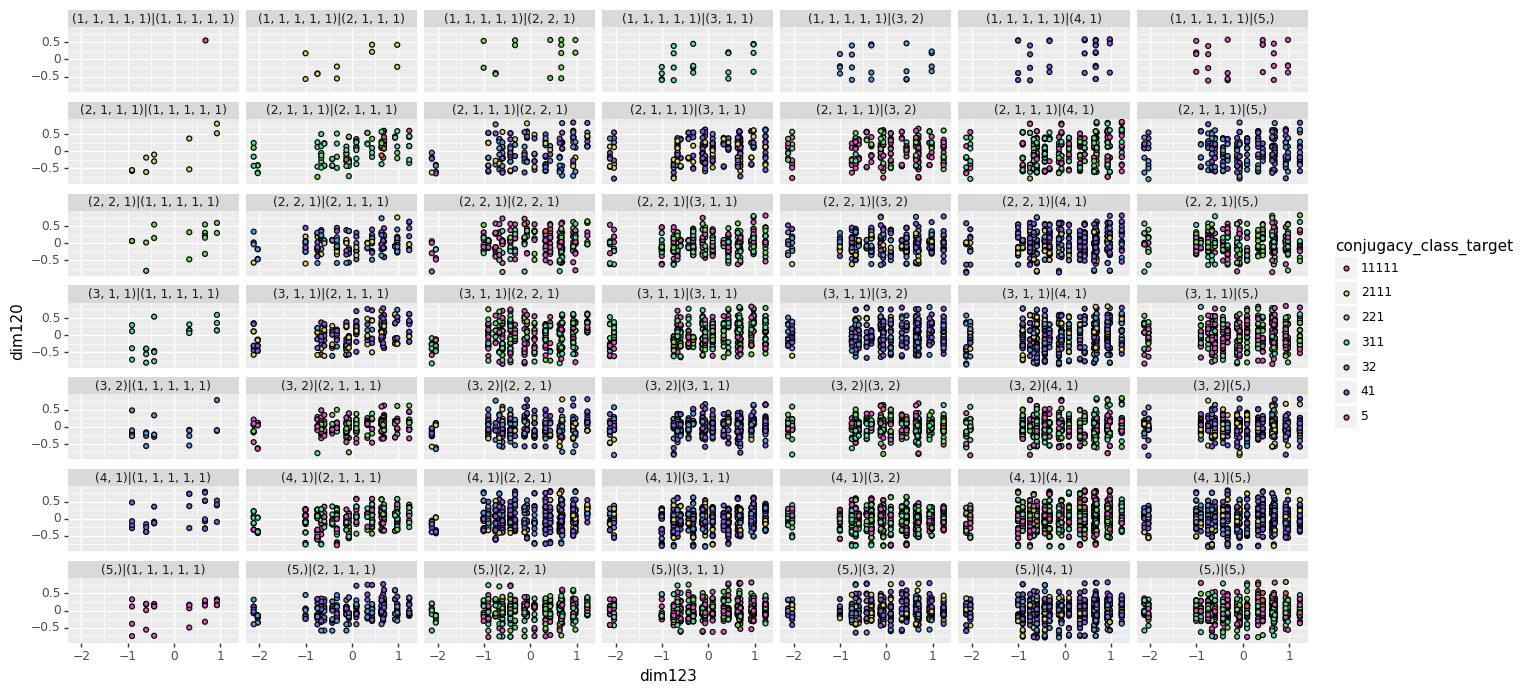

<ggplot: (722243401)>

In [552]:

df = (linear_df
 .select(['permutation_left', 'permutation_right', 'irrep_left', 'irrep_right', 'dim120', 'dim123'])
 .join(s5_df.select(['permutation', 'conjugacy_class']).rename({'conjugacy_class': 'conjugacy_class_left'}), left_on='permutation_left', right_on='permutation', how='inner')
 .join(s5_df.select(['permutation', 'conjugacy_class']).rename({'conjugacy_class': 'conjugacy_class_right'}), left_on='permutation_right', right_on='permutation', how='inner')
 .with_columns((pl.col('conjugacy_class_left') + "|" + pl.col('conjugacy_class_right')).alias('conjugacy_class'))
 .with_columns((pl.col('permutation_left') + "|" + pl.col('permutation_right')).alias('perm_product'))
 .join(trimmed_down_mult, on='perm_product', how='inner')
 .filter((pl.col('irrep_left') == "(3, 2)") & (pl.col('irrep_right') == "(3, 2)"))
 #.select(['conjugacy_class', 'dim120', 'dim48'])
 #.melt(id_vars='conjugacy_class', variable_name='activations')
)
ggplot(df, aes(x='dim123', y='dim120', fill='conjugacy_class_target')) + geom_point() + facet_wrap('~conjugacy_class') + theme(figure_size=(16, 8))

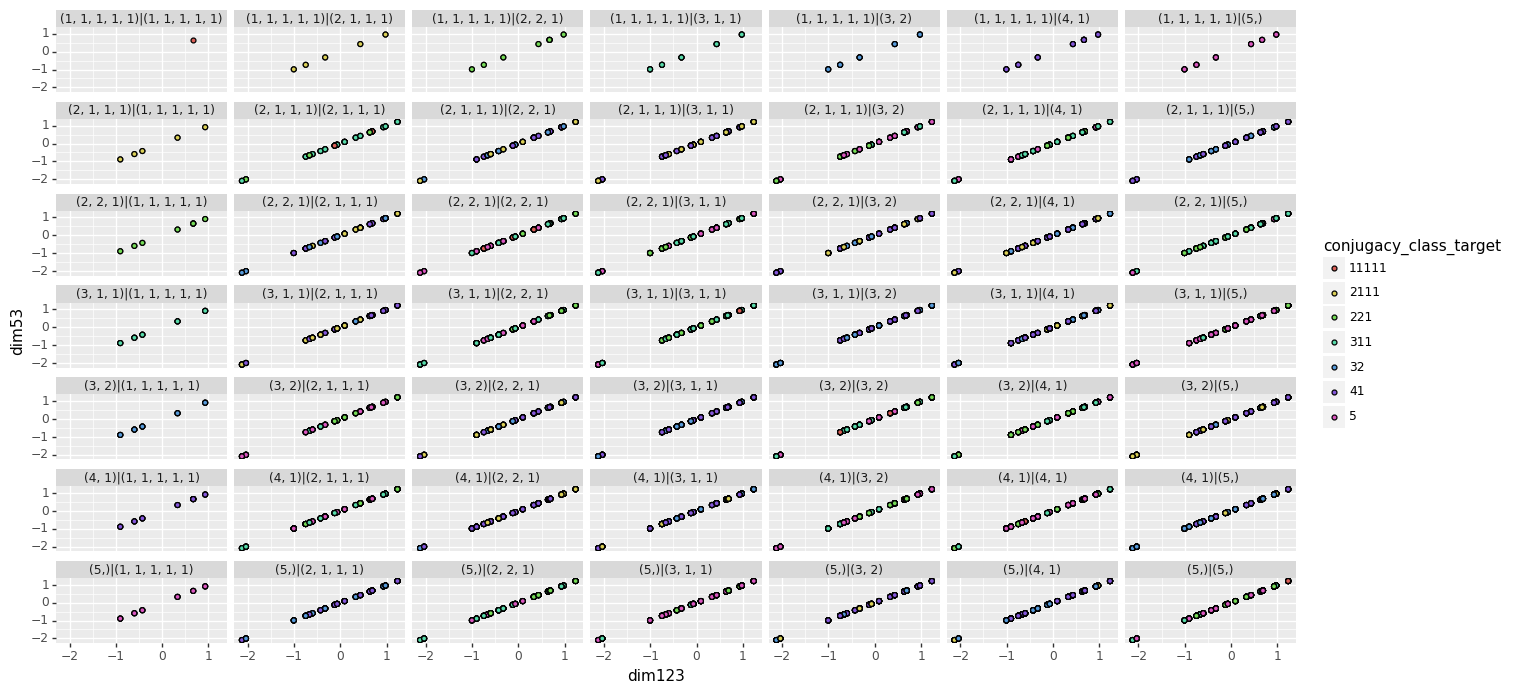

<ggplot: (712004852)>

In [593]:
df = (linear_df
 .select(['permutation_left', 'permutation_right', 'irrep_left', 'irrep_right', 'dim53', 'dim123'])
 .join(s5_df.select(['permutation', 'conjugacy_class']).rename({'conjugacy_class': 'conjugacy_class_left'}), left_on='permutation_left', right_on='permutation', how='inner')
 .join(s5_df.select(['permutation', 'conjugacy_class']).rename({'conjugacy_class': 'conjugacy_class_right'}), left_on='permutation_right', right_on='permutation', how='inner')
 .with_columns((pl.col('conjugacy_class_left') + "|" + pl.col('conjugacy_class_right')).alias('conjugacy_class'))
 .with_columns((pl.col('permutation_left') + "|" + pl.col('permutation_right')).alias('perm_product'))
 .join(trimmed_down_mult, on='perm_product', how='inner')
 .filter((pl.col('irrep_left') == "(3, 2)") & (pl.col('irrep_right') == "(3, 2)"))
 #.select(['conjugacy_class', 'dim120', 'dim48'])
 #.melt(id_vars='conjugacy_class', variable_name='activations')
)
ggplot(df, aes(x='dim123', y='dim53', fill='conjugacy_class_target')) + geom_point() + facet_wrap('~conjugacy_class') + theme(figure_size=(16, 8))

In [598]:
linear_df.filter((pl.col('irrep_left') == "(3, 2)") & (pl.col('irrep_right') == "(3, 2)") & (pl.col('dim123') <= -1.1)).select(['permutation_left', 'permutation_right', 'dim123'])

permutation_left,permutation_right,dim123
str,str,f64
"""(0, 1, 3, 4, 2...","""(0, 3, 1, 2, 4...",-2.12459
"""(0, 1, 3, 4, 2...","""(0, 4, 2, 1, 3...",-2.124885
"""(0, 1, 3, 4, 2...","""(1, 2, 0, 3, 4...",-2.124871
"""(0, 1, 3, 4, 2...","""(1, 4, 3, 0, 2...",-2.124444
"""(0, 1, 3, 4, 2...","""(2, 1, 0, 4, 3...",-2.124978
"""(0, 1, 3, 4, 2...","""(2, 3, 4, 0, 1...",-2.124967
"""(0, 1, 3, 4, 2...","""(3, 0, 1, 4, 2...",-2.124346
"""(0, 1, 3, 4, 2...","""(3, 2, 4, 1, 0...",-2.124767
"""(0, 1, 3, 4, 2...","""(4, 0, 2, 3, 1...",-2.124947


In [624]:
### WHOAH ####
targets = (linear_df.filter(
    (pl.col('irrep_left') == "(3, 2)") & (pl.col('irrep_right') == "(3, 2)") & (pl.col('dim123') <= -1.5)
).join(s5_df.select(['permutation', 'conjugacy_class']).rename({'conjugacy_class': 'conjugacy_class_left'}), left_on='permutation_left', right_on='permutation', how='inner')
 .join(s5_df.select(['permutation', 'conjugacy_class']).rename({'conjugacy_class': 'conjugacy_class_right'}), left_on='permutation_right', right_on='permutation', how='inner')
 .with_columns((pl.col('conjugacy_class_left') + "|" + pl.col('conjugacy_class_right')).alias('conjugacy_class'))
 .with_columns((pl.col('permutation_left') + "|" + pl.col('permutation_right')).alias('perm_product'))
 .join(trimmed_down_mult, on='perm_product', how='inner')
 #.filter(pl.col('conjugacy_class_left') == "(2, 2, 1)")
 .select(['permutation_left', 'permutation_right', 'permutation_target', 'dim123'])
 .sort('permutation_left')
 .groupby(['permutation_target']).count()['permutation_target'].to_list()
)

lperms = (linear_df.filter(
    (pl.col('irrep_left') == "(3, 2)") & (pl.col('irrep_right') == "(3, 2)") & (pl.col('dim123') <= -1.5)
).join(s5_df.select(['permutation', 'conjugacy_class']).rename({'conjugacy_class': 'conjugacy_class_left'}), left_on='permutation_left', right_on='permutation', how='inner')
 .join(s5_df.select(['permutation', 'conjugacy_class']).rename({'conjugacy_class': 'conjugacy_class_right'}), left_on='permutation_right', right_on='permutation', how='inner')
 .with_columns((pl.col('conjugacy_class_left') + "|" + pl.col('conjugacy_class_right')).alias('conjugacy_class'))
 .with_columns((pl.col('permutation_left') + "|" + pl.col('permutation_right')).alias('perm_product'))
 .join(trimmed_down_mult, on='perm_product', how='inner')
 #.filter(pl.col('conjugacy_class_left') == "(2, 2, 1)")
 .select(['permutation_left', 'permutation_right', 'permutation_target', 'dim123'])
 .sort('permutation_left')
 .groupby(['permutation_left']).count()['permutation_left'].to_list()
)

rperms = (linear_df.filter(
    (pl.col('irrep_left') == "(3, 2)") & (pl.col('irrep_right') == "(3, 2)") & (pl.col('dim123') <= -1.5)
).join(s5_df.select(['permutation', 'conjugacy_class']).rename({'conjugacy_class': 'conjugacy_class_left'}), left_on='permutation_left', right_on='permutation', how='inner')
 .join(s5_df.select(['permutation', 'conjugacy_class']).rename({'conjugacy_class': 'conjugacy_class_right'}), left_on='permutation_right', right_on='permutation', how='inner')
 .with_columns((pl.col('conjugacy_class_left') + "|" + pl.col('conjugacy_class_right')).alias('conjugacy_class'))
 .with_columns((pl.col('permutation_left') + "|" + pl.col('permutation_right')).alias('perm_product'))
 .join(trimmed_down_mult, on='perm_product', how='inner')
 #.filter(pl.col('conjugacy_class_left') == "(2, 2, 1)")
 .select(['permutation_left', 'permutation_right', 'permutation_target', 'dim123'])
 .sort('permutation_left')
 .groupby(['permutation_right']).count()['permutation_right'].to_list()
)

In [704]:
combos04132 = (linear_df.filter(
    (pl.col('irrep_left') == "(3, 2)") & (pl.col('irrep_right') == "(3, 2)") & (pl.col('dim123') <= -1.5)
).join(s5_df.select(['permutation', 'conjugacy_class']).rename({'conjugacy_class': 'conjugacy_class_left'}), left_on='permutation_left', right_on='permutation', how='inner')
 .join(s5_df.select(['permutation', 'conjugacy_class']).rename({'conjugacy_class': 'conjugacy_class_right'}), left_on='permutation_right', right_on='permutation', how='inner')
 .with_columns((pl.col('conjugacy_class_left') + "|" + pl.col('conjugacy_class_right')).alias('conjugacy_class'))
 .with_columns((pl.col('permutation_left') + "|" + pl.col('permutation_right')).alias('perm_product'))
 .join(trimmed_down_mult, on='perm_product', how='inner')
 #.filter(pl.col('conjugacy_class_left') == "(2, 2, 1)")
 .filter(pl.col('permutation_target') == "(0, 4, 1, 3, 2)")
 .select(['permutation_left', 'permutation_right']).rows()
 
)

In [705]:
for lp, rp in combos04132:
    print(f'{lp} || {rp}')

(0, 1, 3, 4, 2) || (0, 4, 2, 1, 3)
(0, 2, 1, 4, 3) || (0, 1, 4, 2, 3)
(0, 4, 2, 1, 3) || (0, 3, 1, 2, 4)
(0, 4, 3, 2, 1) || (0, 2, 3, 1, 4)
(1, 0, 4, 3, 2) || (4, 0, 2, 3, 1)
(1, 2, 0, 3, 4) || (1, 0, 4, 3, 2)
(1, 3, 2, 0, 4) || (3, 0, 1, 4, 2)
(1, 3, 4, 2, 0) || (2, 0, 3, 4, 1)
(2, 0, 4, 1, 3) || (4, 3, 0, 2, 1)
(2, 1, 3, 0, 4) || (3, 4, 0, 1, 2)
(2, 3, 1, 4, 0) || (2, 1, 0, 4, 3)
(2, 4, 0, 3, 1) || (1, 2, 0, 3, 4)
(3, 1, 0, 2, 4) || (1, 4, 3, 0, 2)
(3, 1, 2, 4, 0) || (2, 4, 1, 0, 3)
(3, 2, 4, 1, 0) || (2, 3, 4, 0, 1)
(3, 4, 0, 1, 2) || (1, 3, 2, 0, 4)
(4, 0, 1, 2, 3) || (4, 1, 3, 2, 0)
(4, 0, 2, 3, 1) || (4, 2, 1, 3, 0)
(4, 2, 3, 0, 1) || (3, 2, 4, 1, 0)
(4, 3, 1, 0, 2) || (3, 1, 2, 4, 0)
(0, 1, 4, 3, 2) || (0, 4, 2, 3, 1)
(0, 2, 1, 3, 4) || (0, 1, 4, 3, 2)
(0, 3, 2, 1, 4) || (0, 3, 1, 4, 2)
(0, 3, 4, 2, 1) || (0, 2, 3, 4, 1)
(1, 0, 3, 4, 2) || (4, 0, 2, 1, 3)
(1, 2, 0, 4, 3) || (1, 0, 4, 2, 3)
(1, 4, 2, 0, 3) || (3, 0, 1, 2, 4)
(1, 4, 3, 2, 0) || (2, 0, 3, 1, 4)
(2, 0, 3, 1, 4) || (

In [738]:
combos31042 = (linear_df.filter(
    (pl.col('irrep_left') == "(3, 2)") & (pl.col('irrep_right') == "(3, 2)") & (pl.col('dim123') <= -1.5)
).join(s5_df.select(['permutation', 'conjugacy_class']).rename({'conjugacy_class': 'conjugacy_class_left'}), left_on='permutation_left', right_on='permutation', how='inner')
 .join(s5_df.select(['permutation', 'conjugacy_class']).rename({'conjugacy_class': 'conjugacy_class_right'}), left_on='permutation_right', right_on='permutation', how='inner')
 .with_columns((pl.col('conjugacy_class_left') + "|" + pl.col('conjugacy_class_right')).alias('conjugacy_class'))
 .with_columns((pl.col('permutation_left') + "|" + pl.col('permutation_right')).alias('perm_product'))
 .join(trimmed_down_mult, on='perm_product', how='inner')
 #.filter(pl.col('conjugacy_class_left') == "(2, 2, 1)")
 .filter(pl.col('permutation_target') == "(3, 1, 0, 4, 2)")
 .sort('permutation_left')
 .select(['permutation_left', 'permutation_right']).rows()
 
)
                                                   
for lp, rp in combos31042:
    #print(f'{lp} || {rp}')
    print(f'{Permutation(eval(lp)).transposition_decomposition()} ###### {Permutation(eval(rp)).transposition_decomposition()}')

[(2, 4), (3, 4)] ###### [(0, 3)]
[(2, 4)] ###### [(0, 4), (3, 4)]
[(1, 2)] ###### [(0, 1), (1, 2), (2, 4), (3, 4)]
[(3, 4), (1, 2)] ###### [(0, 1), (1, 2), (2, 3)]
[(1, 3)] ###### [(0, 2), (2, 4), (1, 4), (1, 3)]
[(1, 4), (2, 4), (2, 3)] ###### [(0, 4), (2, 4), (1, 2), (1, 3)]
[(1, 3), (3, 4)] ###### [(0, 2), (2, 3), (1, 4)]
[(2, 3), (1, 4)] ###### [(1, 4), (2, 4), (0, 3)]
[(2, 4), (3, 4), (0, 1)] ###### [(0, 3), (1, 3)]
[(2, 4), (0, 1)] ###### [(0, 4), (3, 4), (1, 3)]
[(0, 2), (1, 2)] ###### [(1, 2), (2, 4), (3, 4)]
[(0, 2), (1, 2), (3, 4)] ###### [(1, 2), (2, 3)]
[(0, 3), (1, 3)] ###### [(0, 2), (2, 4), (1, 3)]
[(0, 4), (2, 4), (2, 3), (1, 3)] ###### [(0, 4), (2, 4), (1, 3)]
[(0, 3), (3, 4), (1, 4)] ###### [(0, 2), (2, 3), (1, 3), (1, 4)]
[(0, 4), (1, 4), (2, 3)] ###### [(0, 3), (1, 3), (1, 4), (2, 4)]
[(0, 1), (1, 3), (2, 3)] ###### [(0, 3), (2, 3), (2, 4), (1, 4)]
[(0, 1), (1, 3), (3, 4), (2, 4)] ###### [(0, 4), (1, 4), (2, 3)]
[(0, 3), (2, 3)] ###### [(0, 3), (2, 3), (2, 4)]
[(0, 

In [758]:
def inverse(permutation):
        
        perm = deepcopy(permutation)
        i = 0
        while not perm.is_identity():
            old_perm = perm
            perm = permutation * old_perm
            i += 1
        return old_perm


(inverse(Permutation((0, 1, 4, 3, 2))) * Permutation((3, 1, 0, 4, 2))).transposition_decomposition()
#Permutation((3, 1, 0, 4, 2)).transposition_decomposition()

[(0, 4), (3, 4)]

In [733]:
transpositions = []
for p in sorted(targets):
    transpositions += Permutation(eval(p)).transposition_decomposition()
    
print(set(transpositions))

{(0, 1), (2, 4), (1, 2), (0, 4), (3, 4), (0, 3), (1, 4), (2, 3), (0, 2), (1, 3)}


In [700]:



for t in sorted(targets):
    p = Permutation(eval(t))
    inv = inverse(p)
    if p.order != 2:
        print(f'{t}: inverse in targets? {str(inv.sigma) in targets} lperms? {str(inv.sigma) in lperms} rperms? {str(inv.sigma) in rperms} ')

(0, 2, 4, 1, 3): inverse in targets? False lperms? False rperms? True 
(0, 3, 2, 4, 1): inverse in targets? False lperms? True rperms? True 
(0, 4, 1, 3, 2): inverse in targets? False lperms? False rperms? False 
(1, 2, 3, 4, 0): inverse in targets? False lperms? True rperms? False 
(1, 3, 4, 0, 2): inverse in targets? False lperms? False rperms? False 
(1, 4, 0, 2, 3): inverse in targets? False lperms? False rperms? True 
(2, 0, 1, 4, 3): inverse in targets? False lperms? True rperms? True 
(2, 1, 4, 3, 0): inverse in targets? False lperms? False rperms? False 
(2, 4, 3, 0, 1): inverse in targets? False lperms? False rperms? True 
(3, 0, 4, 2, 1): inverse in targets? False lperms? False rperms? True 
(3, 1, 0, 4, 2): inverse in targets? False lperms? True rperms? False 
(3, 4, 2, 1, 0): inverse in targets? False lperms? False rperms? False 
(4, 0, 3, 1, 2): inverse in targets? False lperms? True rperms? False 
(4, 1, 2, 0, 3): inverse in targets? False lperms? True rperms? True 
(4, 2

In [671]:
[Permutation(p).cycle_rep for p in [(0, 2, 1, 3), (1, 3, 0, 2), (2, 1, 3, 0), (3, 0, 2, 1)]]

[[(1, 2), (3,), (0,)], [(0, 2, 3, 1)], [(0, 3, 2), (1,)], [(0, 1, 3), (2,)]]

In [724]:
print(Permutation((0, 1, 2, 4, 3)).cycle_rep)
print(Permutation((3, 1, 0, 4, 2)).cycle_rep)

[(3, 4), (2,), (1,), (0,)]
[(0, 2, 4, 3), (1,)]


In [742]:
for p in targets:
    print(Permutation(eval(p)).transposition_decomposition())

[(0, 3), (2, 3), (1, 4)]
[(0, 2), (2, 3), (3, 4), (1, 4)]
[(0, 3), (3, 4)]
[(0, 3), (1, 3), (2, 4)]
[(1, 2), (0, 3)]
[(1, 4), (3, 4)]
[(0, 4), (1, 4), (1, 3)]
[(0, 4), (2, 4)]
[(2, 3)]
[(1, 3), (3, 4), (2, 4)]
[(0, 2), (2, 4), (3, 4)]
[(0, 1)]
[(0, 1), (1, 3), (2, 3), (2, 4)]
[(1, 2), (2, 4)]
[(0, 1), (1, 2), (3, 4)]
[(0, 1), (1, 4), (2, 4), (2, 3)]
[(0, 2), (1, 2), (1, 4)]
[(1, 3), (0, 2)]
[(1, 2), (2, 3), (0, 4)]
[(0, 4), (3, 4), (2, 3), (1, 2)]


In [761]:
def generate_subgroup(generators: list[tuple[int]]):
    group_size = 0
    all_perms = set(generators)
    while group_size < len(all_perms):
        group_size = len(all_perms)
        perms = [Permutation(p) for p in all_perms]
        for perm1, perm2 in product(perms, repeat=2):
            perm3 = perm1 * perm2
            all_perms.add(perm3.sigma)
    return list(all_perms)


frob_groups = set()

for p in targets:
    permutation = Permutation(eval(p))
    generators = [(inverse(permutation) * Permutation(eval(t))).sigma for t in targets]
    subgroup = tuple(sorted(generate_subgroup(generators)))
    frob_groups.add(subgroup)
    print(p, len(subgroup))

len(frob_groups)

(2, 4, 3, 0, 1) 20
(1, 4, 0, 2, 3) 20
(4, 1, 2, 0, 3) 20
(1, 3, 4, 0, 2) 20
(3, 2, 1, 0, 4) 20
(0, 3, 2, 4, 1) 20
(3, 4, 2, 1, 0) 20
(2, 1, 4, 3, 0) 20
(0, 1, 3, 2, 4) 20
(0, 2, 4, 1, 3) 20
(3, 1, 0, 4, 2) 20
(1, 0, 2, 3, 4) 20
(4, 0, 3, 1, 2) 20
(0, 4, 1, 3, 2) 20
(2, 0, 1, 4, 3) 20
(3, 0, 4, 2, 1) 20
(4, 2, 0, 3, 1) 20
(2, 3, 0, 1, 4) 20
(4, 3, 1, 2, 0) 20
(1, 2, 3, 4, 0) 20


1

In [762]:
subgroup

((0, 1, 2, 3, 4),
 (0, 2, 1, 4, 3),
 (0, 3, 4, 2, 1),
 (0, 4, 3, 1, 2),
 (1, 0, 3, 2, 4),
 (1, 2, 4, 3, 0),
 (1, 3, 0, 4, 2),
 (1, 4, 2, 0, 3),
 (2, 0, 4, 1, 3),
 (2, 1, 3, 4, 0),
 (2, 3, 1, 0, 4),
 (2, 4, 0, 3, 1),
 (3, 0, 2, 4, 1),
 (3, 1, 4, 0, 2),
 (3, 2, 0, 1, 4),
 (3, 4, 1, 2, 0),
 (4, 0, 1, 3, 2),
 (4, 1, 0, 2, 3),
 (4, 2, 3, 0, 1),
 (4, 3, 2, 1, 0))

In [745]:
permutation = Permutation((2, 4, 3, 0, 1))
inverse = inverse(permutation)
inverse


Permutation [3, 4, 0, 2, 1]

In [746]:
generators = [(inverse * Permutation(eval(t))).sigma for t in targets]

In [777]:
f20 = [str(g) for g in generators]

for f in f20:
    if f in lperms:
        fperm = Permutation(eval(f))
        print(f, fperm.cycle_rep)
        


(0, 3, 4, 2, 1) [(1, 4, 2, 3), (0,)]
(0, 2, 1, 4, 3) [(3, 4), (1, 2), (0,)]
(3, 0, 2, 4, 1) [(0, 1, 4, 3), (2,)]
(4, 1, 0, 2, 3) [(0, 2, 3, 4), (1,)]
(2, 4, 0, 3, 1) [(1, 4), (0, 2), (3,)]
(2, 0, 4, 1, 3) [(0, 1, 3, 4, 2)]
(1, 4, 2, 0, 3) [(0, 3, 4, 1), (2,)]
(4, 2, 3, 0, 1) [(0, 3, 2, 1, 4)]


In [768]:
# 1 2 4 3

for t in targets:
    frob20 = generate_subgroup([(4, 0, 1, 2, 3), eval(t)])
    if len(frob20) == 20:
        print(t)
    elif len(frob20) < 20:
        print(t, len(frob20))


(3, 2, 1, 0, 4) 10
(0, 2, 4, 1, 3)
(4, 2, 0, 3, 1)
(1, 2, 3, 4, 0) 5


In [790]:
Permutation((4, 0, 1, 2, 3)) ** 4

Permutation [1, 2, 3, 4, 0]

In [791]:
b = Permutation((0, 2, 4, 1, 3))
b_inv = inverse(b)
a = Permutation((4, 0, 1, 2, 3))


In [804]:
a ** 3

Permutation [2, 3, 4, 0, 1]

In [805]:
four_cycles = [s for s in S5 if s.conjugacy_class == (4, 1)]
will_gen_frob20 = []

for fc in four_cycles:
    print(fc)
    conj = fc * a * (fc ** 3)
    if conj.sigma == (2, 3, 4, 0, 1):
        will_gen_frob20.append(fc.sigma)
    

Permutation [0, 2, 3, 4, 1]
Permutation [0, 2, 4, 1, 3]
Permutation [0, 3, 1, 4, 2]
Permutation [0, 3, 4, 2, 1]
Permutation [0, 4, 1, 2, 3]
Permutation [0, 4, 3, 1, 2]
Permutation [1, 2, 3, 0, 4]
Permutation [1, 2, 4, 3, 0]
Permutation [1, 3, 0, 2, 4]
Permutation [1, 3, 2, 4, 0]
Permutation [1, 4, 0, 3, 2]
Permutation [1, 4, 2, 0, 3]
Permutation [2, 0, 3, 1, 4]
Permutation [2, 0, 4, 3, 1]
Permutation [2, 1, 3, 4, 0]
Permutation [2, 1, 4, 0, 3]
Permutation [2, 3, 1, 0, 4]
Permutation [2, 4, 1, 3, 0]
Permutation [3, 0, 1, 2, 4]
Permutation [3, 0, 2, 4, 1]
Permutation [3, 1, 0, 4, 2]
Permutation [3, 1, 4, 2, 0]
Permutation [3, 2, 0, 1, 4]
Permutation [3, 4, 2, 1, 0]
Permutation [4, 0, 1, 3, 2]
Permutation [4, 0, 2, 1, 3]
Permutation [4, 1, 0, 2, 3]
Permutation [4, 1, 3, 0, 2]
Permutation [4, 2, 0, 3, 1]
Permutation [4, 3, 2, 0, 1]


In [806]:
will_gen_frob20

[(0, 2, 4, 1, 3),
 (1, 3, 0, 2, 4),
 (2, 4, 1, 3, 0),
 (3, 0, 2, 4, 1),
 (4, 1, 3, 0, 2)]

In [752]:
frob20_ = generate_subgroup([(4, 0, 1, 2, 3), (3, 1, 0, 4, 2)])

In [807]:
generators

[(1, 2, 4, 3, 0),
 (3, 1, 4, 0, 2),
 (3, 4, 1, 2, 0),
 (2, 1, 3, 4, 0),
 (4, 3, 2, 1, 0),
 (1, 0, 3, 2, 4),
 (0, 3, 4, 2, 1),
 (0, 2, 1, 4, 3),
 (4, 0, 1, 3, 2),
 (3, 0, 2, 4, 1),
 (2, 3, 1, 0, 4),
 (4, 1, 0, 2, 3),
 (2, 4, 0, 3, 1),
 (2, 0, 4, 1, 3),
 (3, 2, 0, 1, 4),
 (1, 3, 0, 4, 2),
 (1, 4, 2, 0, 3),
 (4, 2, 3, 0, 1),
 (0, 4, 3, 1, 2),
 (0, 1, 2, 3, 4)]

In [810]:
for s in subgroup:
    if s in will_gen_frob20:
        print(s)

(3, 0, 2, 4, 1)


In [811]:
subgroup2 = generate_subgroup([(4, 0, 1, 2, 3), (0, 2, 4, 1, 3)])
len(subgroup2)

20

In [814]:
set(subgroup).intersection(set(subgroup))

20

In [835]:
def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    fourier_transform = slow_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, math.factorial(n))
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().numpy(), schema=[f'dim{i}' for i in range(256)])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform




In [825]:
from pathlib import Path

ckpt_dir = Path('checkpoints/s5_50_02')



In [839]:
#for f in ckpt_dir.glob('*.pth'):
#    print(f)

def _frob_norm(ft_vals):
    dim = ft_vals.dim()
    if dim < 2:
        return ft_vals**2
    else:
        dim = ft_vals.shape[0]
        return dim * torch.trace(ft_vals.T @ ft_vals)


batch_kron = functorch.vmap(torch.kron, in_dims=(0, 0))
frob = functorch.vmap(_frob_norm, in_dims=0)



def calc_power(ft, group_order):
    return {k: (frob(v) / group_order**2)  for k, v in ft.items()}



def embedding_harmonic_analysis(checkpoint, config, epoch):
    #run = torch.load(checkpoint, map_location=torch.device('cpu'))
    model = SnMLP.from_config(config)
    model.load_state_dict(checkpoint)
    lembed_power_df, lembed_fourier_transform = calc_power_contributions(
        model.lembed.weight.to(torch.float64), 5
    )
    lembed_power_df.insert_at_idx(0, pl.Series('layer', ['left_embed'] * lembed_power_df.shape[0]))
    rembed_power_df, rembed_fourier_transform = calc_power_contributions(
        model.rembed.weight.to(torch.float64), 5
    )
    rembed_power_df.insert_at_idx(0, pl.Series('layer', ['right_embed'] * lembed_power_df.shape[0]))
    epochs = pl.Series('epoch', [epoch] * lembed_power_df.shape[0])
    lembed_power_df.insert_at_idx(0, epochs)
    rembed_power_df.insert_at_idx(0, epochs)
    return (
        pl.concat([lembed_power_df, rembed_power_df], how='vertical'),
        {'left_embed': lembed_fourier_transform, 'right_embed': rembed_fourier_transform}
    )



    

In [840]:
run['checkpoint_epochs'][5]

32

In [841]:
power_df, fourier_tensors = embedding_harmonic_analysis(run['checkpoints'][5], run['config'], run['checkpoint_epochs'][5])

In [843]:
power_df.select(pl.all().exclude(['epoch'])).head()

layer,irrep,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,dim34,...,dim219,dim220,dim221,dim222,dim223,dim224,dim225,dim226,dim227,dim228,dim229,dim230,dim231,dim232,dim233,dim234,dim235,dim236,dim237,dim238,dim239,dim240,dim241,dim242,dim243,dim244,dim245,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,...,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""left_embed""","""(1, 1, 1, 1, 1...",0.004945,0.016931,0.016768,0.002077,0.000596,0.000003,0.004087,0.001719,0.001457,0.016722,0.003674,0.004467,0.007382,0.001124,0.000025,0.003786,0.000007,0.00027,0.002159,0.022227,0.006236,0.005666,0.003373,0.000178,0.007736,0.035359,0.017278,0.016175,0.01008,0.004036,0.017974,0.034452,0.001794,0.008809,0.020853,...,0.000189,0.007468,0.000147,7.6298e-7,0.014347,0.004898,4.3398e-7,0.001928,0.002837,0.000906,0.002518,0.023915,0.026551,0.010003,0.004096,0.00105,0.016333,0.000604,0.000345,0.027212,0.009219,0.044106,0.027,0.00725,0.017011,0.000663,0.002643,0.007598,0.001013,0.002152,0.016336,0.018867,0.001469,0.000988,0.00295,0.006466,0.000108
"""left_embed""","""(2, 1, 1, 1)""",0.129089,0.095961,0.146412,0.133014,0.131577,0.188315,0.121343,0.093313,0.076321,0.165333,0.135203,0.129532,0.168413,0.162104,0.144667,0.130427,0.133455,0.297697,0.176795,0.164447,0.121654,0.197393,0.07743,0.118908,0.092327,0.098914,0.146308,0.091487,0.11801,0.079345,0.124173,0.121436,0.103527,0.176903,0.142278,...,0.180274,0.153317,0.16987,0.09953,0.11103,0.100954,0.118712,0.231117,0.171254,0.130358,0.210065,0.145753,0.070965,0.089541,0.119882,0.205444,0.129144,0.137725,0.133527,0.113991,0.121947,0.112514,0.139371,0.158732,0.092621,0.13866,0.12892,0.147662,0.087934,0.061031,0.098435,0.050054,0.180128,0.161723,0.151091,0.159992,0.051263
"""left_embed""","""(2, 2, 1)""",0.172661,0.187647,0.141239,0.236863,0.183532,0.225339,0.222767,0.214776,0.293204,0.216109,0.230317,0.175276,0.226132,0.17692,0.22236,0.203336,0.283606,0.220074,0.154157,0.138603,0.163394,0.193325,0.159248,0.178724,0.145786,0.168368,0.147727,0.249728,0.205023,0.32974,0.161238,0.284344,0.295519,0.252792,0.135699,...,0.169328,0.214515,0.156449,0.271626,0.112266,0.227694,0.192521,0.262294,0.15866,0.221185,0.125268,0.124055,0.170713,0.149367,0.171881,0.278105,0.213338,0.258317,0.170388,0.205054,0.231757,0.208787,0.192735,0.291998,0.139357,0.199338,0.256173,0.215248,0.172972,0.25865,0.129591,0.307138,0.249526,0.24237,0.181684,0.206023,0.206574
"""left_embed""","""(3, 1, 1)""",0.35888,0.261376,0.264212,0.292548,0.340472,0.299088,0.321202,0.267154,0.325319,0.353451,0.310924,0.258912,0.236843,0.337565,0.359624,0.390479,0.30832,0.179317,0.317765,0.346625,0.287074,0.322084,0.40331,0.33901,0.371871,0.285593,0.219532,0.239309,0.273409,0.274186,0.424973,0.269557,0.269479,0.303768,0.305552,...,0.248166,0.197733,0.219901,0.433816,0.37909,0.304846,0.35424,0.253817,0.32452,0.247452,0.231967,0.320558,0.261594,0.420692,0.25689,0.238461,0.316815,0.301542,0.311286,0.282407,0.319348,0.273507,0.326876,0.323389,0.341615,0.293276,0.27267,0.23731,0.369448,0.374882,0.232858,0.223823,0.168237,0.287452,0.293698,0.30573,0.250658
"""left_embed""","""(3, 2)""",0.144909,0.186941,0.32134,0.162093,0.244347,0.15055,0.229373,0.249874,0.136214,0.152162,0.177575,0.256784,0.21158,0.25535,0.135413,0.183291,0.176703,0.137652,0.237044,0.206749,0.238245,0.172546,0.231148,0.208987,0.285318,0.262516,0.262701,0.325106,0.248799,0.162416,0.137943,0.107035,0.128656,0.128262,0.227616,...,0.238276,0.306258,0.320052,0.14739,0.261751,0.268841,0.214513,0.157803,0.232148,0.2362,0.262704,0.21203,0.301579,0.223424,0.290719,0.161392,0.184936,0.128505,0.2

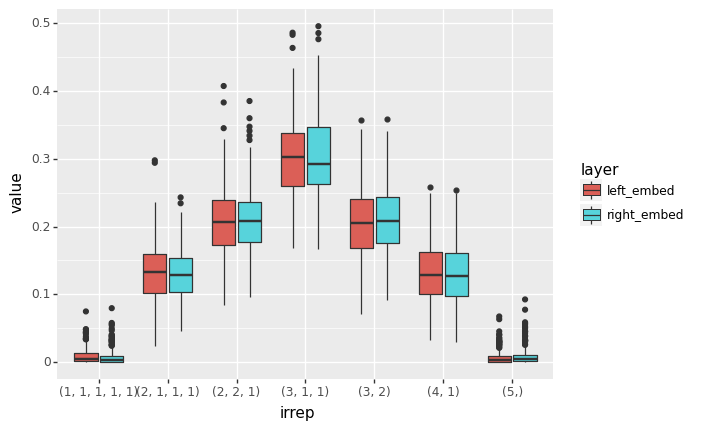

<ggplot: (709974986)>

In [844]:
from plotnine import geom_boxplot 
ggplot(
    power_df.select(pl.all().exclude(['epoch'])).melt(id_vars=['irrep', 'layer']), 
    aes(x='irrep', y='value', fill='layer')) + geom_boxplot() 

In [853]:
from plotnine import lims
from plotnine.animation import PlotnineAnimation

from matplotlib import rc
rc('animation', html='html5')

def make_plot(data):
    #data, _ =  embedding_harmonic_analysis(checkpoint, config, epoch)
    plot = ggplot(
        data.select(pl.all().exclude(['epoch'])).melt(id_vars=['irrep', 'layer']), 
        aes(x='irrep', y='value', fill='layer')
    )
    plot = plot + geom_boxplot() + lims(y=(0.0, 1.0))
    return plot



In [852]:
#plot_iter = (make_plot(ckpt, epoch, run['config']) for ckpt, epoch in zip(run['checkpoints'], run['checkpoint_epochs']))
#ani = PlotnineAnimation(plot_iter, interval=100, repeat_delay=500)
#ani
from pathlib import Path

ft_dir = Path('checkpoints/s5_50_02/harmonics/ft')

embedding_data = []

for ckpt, epoch in zip(run['checkpoints'], run['checkpoint_epochs']):
    data, ft_tensors =  embedding_harmonic_analysis(ckpt, run['config'], epoch)
    embedding_data.append(data)
    torch.save(ft_tensors, ft_dir / f'{epoch}.pth')


In [856]:
#plot_iter = (make_plot(df) for df in embedding_data)
#ani = PlotnineAnimation(plot_iter, interval=100, repeat_delay=500)
#ani


embedding_run_df = pl.concat(embedding_data, how='vertical')

In [863]:
run_power_summary = (
    embedding_run_df
    .melt(id_vars=['epoch', 'layer', 'irrep'])
    .groupby(['epoch', 'layer', 'irrep'])
    .agg([
        pl.col('value').mean().alias('mean_power'),
        pl.col('value').quantile(0.25).alias('q25'),
        pl.col('value').quantile(0.75).alias('q75')
    ])
    .sort(['epoch', 'layer', 'irrep'])
)

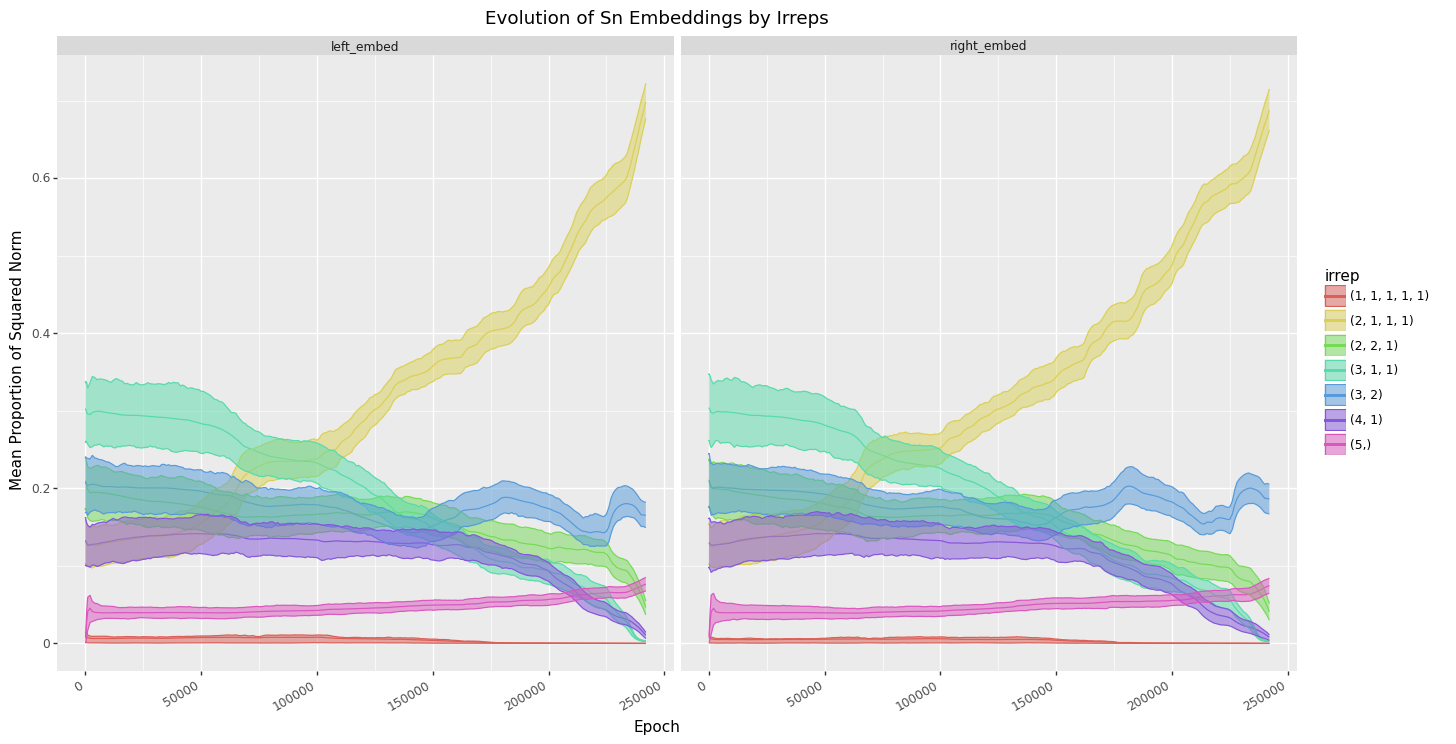

<ggplot: (811526391)>

In [884]:
from plotnine import geom_line, geom_ribbon, scale_x_log10

(
    ggplot(run_power_summary, aes(x='epoch', color='irrep'))
    + geom_line(aes(y='mean_power'))
    #+ scale_x_log10()
    + geom_ribbon(aes(ymin='q25', ymax='q75', fill='irrep'), alpha=0.5) 
    + facet_wrap('~layer')
    + theme(axis_text_x=element_text(rotation=30, hjust=1), figure_size=(16, 8))
    + xlab('Epoch') + ylab('Mean Proportion of Squared Norm')
    + ggtitle('Evolution of Sn Embeddings by Irreps')
)

In [ ]:
### Set up
import math
import numpy as np
from plotnine import (
    ggplot,
    aes,
    theme, 
    element_text,
    stat_smooth,
    facet_wrap,
    geom_tile,
    geom_point,
    geom_histogram,
    geom_violin,
    geom_col,
    xlab,
    ylab,
    ggtitle
)
import polars as pl
import torch
import functorch



from sngrok.fourier import slow_ft_1d, slow_ft_2d, sn_fourier_basis, sn_fourier_basis_2d
from sngrok.permutations import Permutation, make_permutation_dataset
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep


In [ ]:
def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    fourier_transform = slow_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, math.factorial(n))
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().numpy(), schema=[f'dim{i}' for i in range(256)])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform



def embedding_harmonic_analysis(checkpoint, config, epoch):
    #run = torch.load(checkpoint, map_location=torch.device('cpu'))
    model = SnMLP.from_config(config)
    model.load_state_dict(checkpoint)
    lembed_power_df, lembed_fourier_transform = calc_power_contributions(
        model.lembed.weight.to(torch.float64), 5
    )
    lembed_power_df.insert_at_idx(0, pl.Series('layer', ['left_embed'] * lembed_power_df.shape[0]))
    rembed_power_df, rembed_fourier_transform = calc_power_contributions(
        model.rembed.weight.to(torch.float64), 5
    )
    rembed_power_df.insert_at_idx(0, pl.Series('layer', ['right_embed'] * lembed_power_df.shape[0]))
    epochs = pl.Series('epoch', [epoch] * lembed_power_df.shape[0])
    lembed_power_df.insert_at_idx(0, epochs)
    rembed_power_df.insert_at_idx(0, epochs)
    return (
        pl.concat([lembed_power_df, rembed_power_df], how='vertical'),
        {'left_embed': lembed_fourier_transform, 'right_embed': rembed_fourier_transform}
    )


In [ ]:







run = torch.load('checkpoints/s5_50_02/full_run.pth', map_location=torch.device('cpu'))
from pathlib import Path



runs = ['s5_50_02', 's5_50_3', 's5_50_4', 's5_50_5', 's5_50_6', 's5_50_7']
ckpt_dir = Path('checkpoints')

for run in runs:
    
    
    
def training_plot(run):
    
    model_run = torch.load(f'checkpoints/{run}/full_run.pth', map_location=torch.device('cpu'))
    ft_dir = ckpt_dir / f'{run}/harmonics/ft'
    ft_dir.mkdir(parents=True, exist_ok=True)

    embedding_data = []

    for ckpt, epoch in zip(model_run['checkpoints'], model_run['checkpoint_epochs']):
        data, ft_tensors =  embedding_harmonic_analysis(ckpt, model_run['config'], epoch)
        embedding_data.append(data)
        torch.save(ft_tensors, ft_dir / f'{epoch}.pth')
    
    embedding_run_df = pl.concat(embedding_data, how='vertical')
    embedding_run_df.write_parquet(f'checkpoints/{run}/harmonics/embed_power.parquet')
    run_power_summary = (
        embedding_run_df
        .melt(id_vars=['epoch', 'layer', 'irrep'])
        .groupby(['epoch', 'layer', 'irrep'])
        .agg([
            pl.col('value').mean().alias('mean_power'),
            pl.col('value').quantile(0.25).alias('q25'),
            pl.col('value').quantile(0.75).alias('q75')
        ])
        .sort(['epoch', 'layer', 'irrep'])
    )
    plot = (
        ggplot(run_power_summary, aes(x='epoch', color='irrep'))
        + geom_line(aes(y='mean_power'))
        #+ scale_x_log10()
        + geom_ribbon(aes(ymin='q25', ymax='q75', fill='irrep'), alpha=0.5) 
        + facet_wrap('~layer')
        + theme(axis_text_x=element_text(rotation=30, hjust=1), figure_size=(16, 8))
        + xlab('Epoch') + ylab('Mean Proportion of Squared Norm')
        + ggtitle(f'Evolution of Sn Embeddings by Irreps: {run}')
    )
    plot.save(f'plots/embed_power/{run}.png')


/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 16 x 8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/embed_power/s5_50_3.png
